Learning to rank.


In [1]:
from wvpy.jtools import declare_task_variables

# set up for external override
with declare_task_variables(globals()):
    rand_seed = 2024
    do_display = True
    result_fname = ""
    m_examples = 200
    score_name = "quality"
    clean_up = False
    show_console = False

In [2]:
# set up Python
import logging
from itertools import product
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import spearmanr
from cmdstanpy import CmdStanModel
from plotnine import *
from rank_plotting_fns import (
    define_Stan_choice_src,
    define_Stan_list_src,
    define_Stan_inspection_src,
    estimate_model_from_scores,
    format_Stan_data,
    format_Stan_inspection_data,
    mk_example,
    plot_rank_performance,
    run_stan_model,
    sort_observations_frame,
    XgboostClassifier,
)

# quiet down Stan
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())

In [3]:
rng = np.random.default_rng(rand_seed)

In [4]:
example_name = "uci wine example"

In [5]:
if do_display:
    print(example_name)

uci wine example


In [6]:

# read data and set scale of system
features_frame = pd.read_csv("uci_wine_example_features.csv")
features_scores = pd.read_csv("uci_wine_example_scores.csv")
m_train_examples: int = m_examples
m_test_examples: int = m_examples
noise_scale = 0.57
continue_inspection_probability = 0.6

know_score: bool = True

In [7]:
features_frame.head()

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,citric acid is white,residual sugar is white,chlorides is white,free sulfur dioxide is white,total sulfur dioxide is white,density is white,pH is white,sulphates is white,alcohol is white,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
features_frame.shape

(6497, 23)

In [9]:
collected_stats = []

In [10]:
n_alternatives: int = 5

In [11]:
n_vars = features_frame.shape[1] + n_alternatives

In [12]:


continue_inspection_probability


0.6

In [13]:
observations_train = mk_example(
    features_frame=features_frame,
    features_scores=features_scores,
    continue_inspection_probability=continue_inspection_probability,
    n_alternatives=n_alternatives,
    m_examples=m_train_examples,
    score_name=score_name,
    noise_scale=noise_scale,
    rng=rng,
)

In [14]:
observations_test = mk_example(
    features_frame=features_frame,
    features_scores=features_scores,
    continue_inspection_probability=continue_inspection_probability,
    n_alternatives=n_alternatives,
    m_examples=m_test_examples,
    score_name=score_name,
    noise_scale=noise_scale,
    rng=rng,
)

In [15]:
perfect_coef = None
if know_score:
    perfect_coef = estimate_model_from_scores(
            observations=observations_train,
            features_frame=features_frame,
        )

In [16]:
# make sure we don't have a column we would not know in practice
observations_train = observations_train.loc[
    :, [c for c in observations_train.columns if not c.startswith("score_value_")]
].reset_index(drop=True, inplace=False)
observations_test = observations_test.loc[
    :, [c for c in observations_test.columns if not c.startswith("score_value_")]
].reset_index(drop=True, inplace=False)

observations_train.head()

,display_position_0,item_id_0,pick_value_0,display_position_1,item_id_1,pick_value_1,display_position_2,item_id_2,pick_value_2,display_position_3,item_id_3,pick_value_3,display_position_4,item_id_4,pick_value_4
0,0,1569,1,1,64,0,2,5467,0,3,5343,0,4,1543,0
1,0,4390,0,1,5815,0,2,5865,1,3,5798,0,4,2083,0
2,0,599,0,1,3610,0,2,4821,0,3,2147,1,4,4012,0
3,0,1392,1,1,6388,0,2,3709,0,3,1309,0,4,4570,0
4,0,2063,1,1,312,0,2,551,0,3,6144,0,4,1883,0


In [17]:
win_frequencies = (
    observations_train
        .loc[
            :, 
            [c for c in observations_train.columns if c.startswith("pick_value_")]]
        .mean(axis=0)
        .reset_index(drop=False, inplace=False)
        .sort_values(['index'], ignore_index=True)
)
win_frequencies.columns = ['position', 'win frequency']

win_frequencies

,position,win frequency
0,pick_value_0,0.545
1,pick_value_1,0.235
2,pick_value_2,0.090
3,pick_value_3,0.075
4,pick_value_4,0.055


In [18]:
# This is the observable data
observations_train[
    [c for c in observations_train.columns if not c.startswith("display_position_")]
].head(10)

,item_id_0,pick_value_0,item_id_1,pick_value_1,item_id_2,pick_value_2,item_id_3,pick_value_3,item_id_4,pick_value_4
0,1569,1,64,0,5467,0,5343,0,1543,0
1,4390,0,5815,0,5865,1,5798,0,2083,0
2,599,0,3610,0,4821,0,2147,1,4012,0
3,1392,1,6388,0,3709,0,1309,0,4570,0
4,2063,1,312,0,551,0,6144,0,1883,0
5,2010,0,1494,1,5669,0,3843,0,5500,0
6,5903,0,5988,0,5107,0,5769,1,4815,0
7,5194,1,2787,0,1050,0,5149,0,1700,0
8,5946,1,2953,0,4371,0,895,0,4712,0
9,6469,1,536,0,2016,0,2200,0,5126,0


In [19]:
score_compare_frame = pd.DataFrame([[] for i in range(features_frame.shape[0])])
if know_score:
    score_compare_frame["hidden concept"] = features_scores[
        score_name
    ]  # would not know this for non-synthetic data

Try a Stan model.


In [20]:
stan_model_inspection_src = define_Stan_inspection_src(n_alternatives=n_alternatives)
if do_display:
    print(stan_model_inspection_src)
data_inspection_str = format_Stan_inspection_data(
    observations=observations_train,
    features_frame=features_frame,
    p_continue=continue_inspection_probability,
)
fit_inspection = run_stan_model(
    stan_model_src=stan_model_inspection_src,
    data_str=data_inspection_str,
    model_note='inspection_model',
    clean_up=clean_up,
    show_console=show_console,
)


data {
  int<lower=1> n_vars;                              // number of variables per alternative
  int<lower=1> m_examples;                          // number of examples
  real<lower=0, upper=1> p_continue;                // modeled probability of inspecting on
  array[m_examples] int<lower=1, upper=5> picked_index;   // which position was picked
  matrix[m_examples, n_vars] x_1;                   // features examples
  matrix[m_examples, n_vars] x_2;                   // features examples
  matrix[m_examples, n_vars] x_3;                   // features examples
  matrix[m_examples, n_vars] x_4;                   // features examples
  matrix[m_examples, n_vars] x_5;                   // features examples
}
parameters {
  vector[n_vars] beta;                              // model parameters
  vector[m_examples] error_picked;                  // reified noise term on picks
}
transformed parameters {
  array[5] vector[m_examples] expected_value;             // modeled expected score of

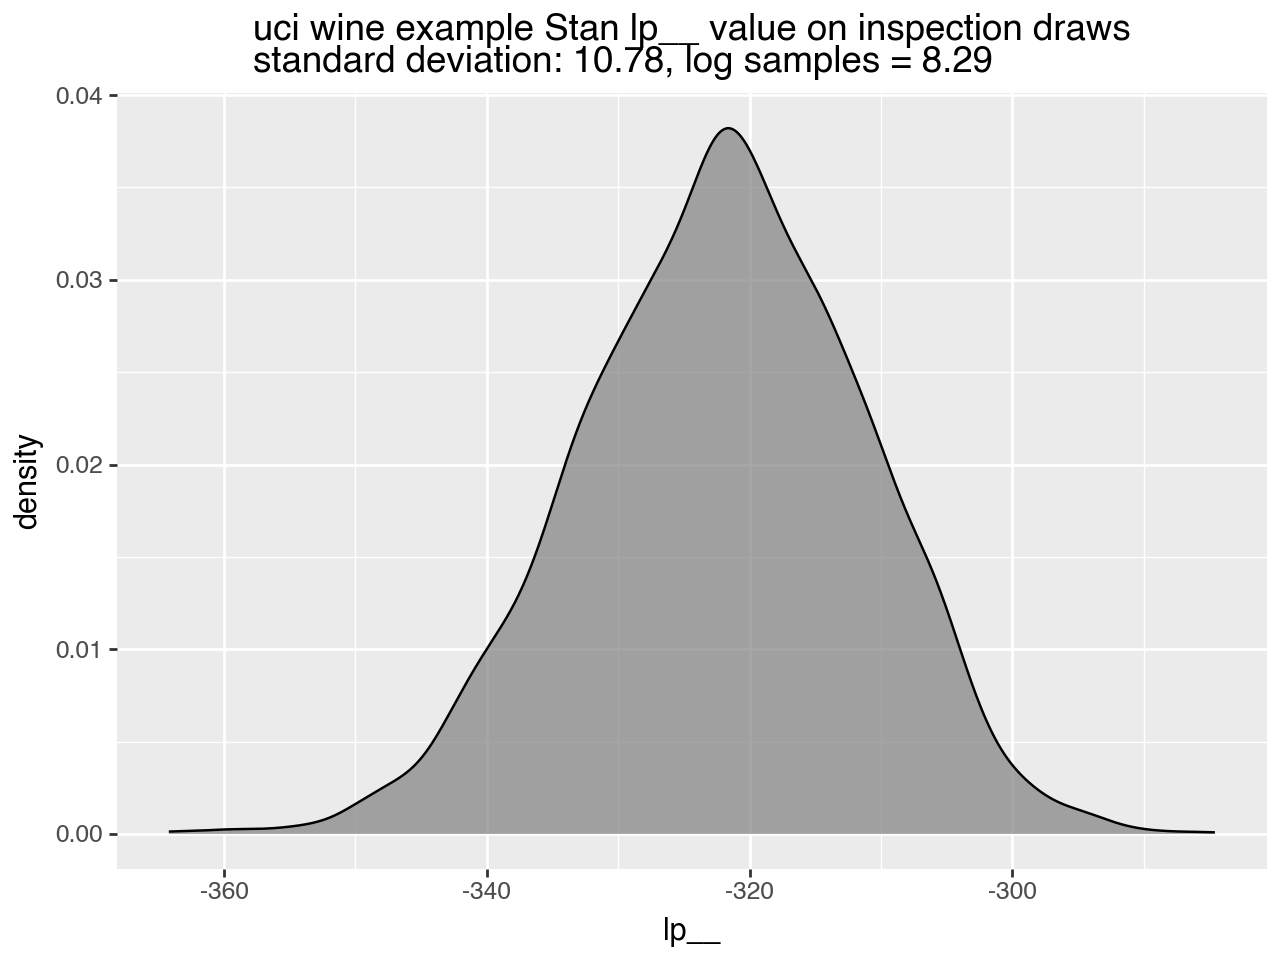

In [21]:
# get implied sample weights from chain
wt_frame_inspection = fit_inspection.draws_pd(vars=["lp__"])

if do_display:
    stddev = np.sqrt(np.var(wt_frame_inspection["lp__"]))
    log_samples = np.log(wt_frame_inspection.shape[0])
    (
        ggplot(
            data=wt_frame_inspection,
            mapping=aes(x="lp__"),
        )
        + geom_density(fill="gray", alpha=0.7)
        + ggtitle(
            f"{example_name} Stan lp__ value on inspection draws\nstandard deviation: {stddev:.2f}, log samples = {log_samples:.2f}"
        )
    ).show()

In [22]:
beta_draws = fit_inspection.draws_pd(vars=["beta"])
beta_draws_display = beta_draws.copy()
beta_draws_display.columns = list(features_frame.columns) 

beta_draws_display

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,citric acid is white,residual sugar is white,chlorides is white,free sulfur dioxide is white,total sulfur dioxide is white,density is white,pH is white,sulphates is white,alcohol is white,is_red
0,1.393350,3.950740,14.87600,-1.333870,-7.95193,1.247860,-0.494486,-6.08727,12.55620,-0.551575,...,-3.078980,0.158019,2.018120,0.310566,0.020521,0.781401,13.268400,-3.71369,6.74791,-24.34270
1,-1.714440,-9.688980,3.74748,2.323520,9.99636,1.029630,-0.492561,5.91340,-19.13880,1.721760,...,2.395830,-0.004718,11.321600,0.265422,-0.021552,-11.466400,0.036315,-2.55644,5.43261,24.75770
2,-0.886795,3.646430,6.95550,-4.081950,14.79490,0.907088,-0.385795,-2.76107,-2.31488,23.048000,...,-14.852000,1.085250,-2.795740,0.220352,0.071111,-3.220040,8.307630,-19.03030,8.55562,4.61785
3,0.296495,-0.069477,-9.41952,2.311990,-4.85855,0.724666,-0.220648,-4.08496,-1.32748,0.166032,...,-2.355960,0.501885,-1.302260,0.215006,0.082517,16.574400,4.783580,-8.93551,7.67617,-1.66537
4,-2.871940,2.673720,16.68710,-2.068190,10.06480,1.278940,-0.316191,0.02473,-14.96500,1.834500,...,-13.089000,0.007300,-29.274200,0.237327,0.009144,-3.817560,-0.915980,-8.16993,4.66173,-5.36921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-2.322340,-9.396280,20.92340,-0.209647,2.69900,2.395750,-0.882241,0.39762,-1.23191,-4.191350,...,-2.872580,0.072785,-11.796100,0.249255,0.011232,4.824880,9.438850,-12.76290,4.19213,-2.12844
3996,0.033964,-8.781870,-9.59366,-1.819190,12.90680,0.581456,-0.247873,1.61629,-5.87684,-4.082890,...,-4.462760,0.348464,11.623500,0.253683,0.048073,6.631950,-1.019690,-9.11665,5.73367,6.45712
3997,2.186790,4.249130,-2.13929,2.725750,10.44000,0.516200,-0.196672,-5.37574,-7.28665,2.798540,...,-14.644800,0.037767,0.879065,0.257775,0.038818,-6.515510,5.221680,-17.53240,5.36686,-11.84030
3998,-0.273586,-6.574890,-9.78200,-0.197057,-6.98624,1.490730,-0.544722,11.94850,-5.75305,15.082200,...,-4.933860,0.371544,3.575260,0.172416,0.091678,2.943770,1.710450,-2.95861,7.93862,3.49641


In [23]:
# this this entirety of what we pull out of Stan- per modeled preference cohort
# from now on we do not use Stan
estimated_beta_inspection_Stan = beta_draws_display.loc[
    wt_frame_inspection["lp__"] >= np.quantile(wt_frame_inspection["lp__"], 0.5), :
].mean()
estimated_beta_inspection_Stan

fixed acidity is red            -0.354786
volatile acidity is red         -1.611675
citric acid is red               4.388216
residual sugar is red           -0.121453
chlorides is red                 1.595568
free sulfur dioxide is red       1.121780
total sulfur dioxide is red     -0.429191
density is red                  -0.851431
pH is red                       -5.123315
sulphates is red                 2.315488
alcohol is red                   9.328614
fixed acidity is white          -0.367537
volatile acidity is white       -3.691849
citric acid is white            -5.624860
residual sugar is white          0.381677
chlorides is white              -1.238351
free sulfur dioxide is white     0.244370
total sulfur dioxide is white    0.023933
density is white                 0.625695
pH is white                      6.256862
sulphates is white              -8.380894
alcohol is white                 5.513627
is_red                          -0.745057
dtype: float64

In [24]:
estimated_beta_inspection_Stan = list(estimated_beta_inspection_Stan) + [0] * n_alternatives  # TODO: clean

picks


,row,position,pick probability estimate,was pick
0,0,0,0.0380,False
1,0,1,0.1570,False
2,0,2,0.0956,False
3,0,3,0.4536,True
4,0,4,0.2558,False
5,1,0,0.0000,False
6,1,1,0.0623,False
7,1,2,0.0512,True
8,1,3,0.3708,False
9,1,4,0.5157,False


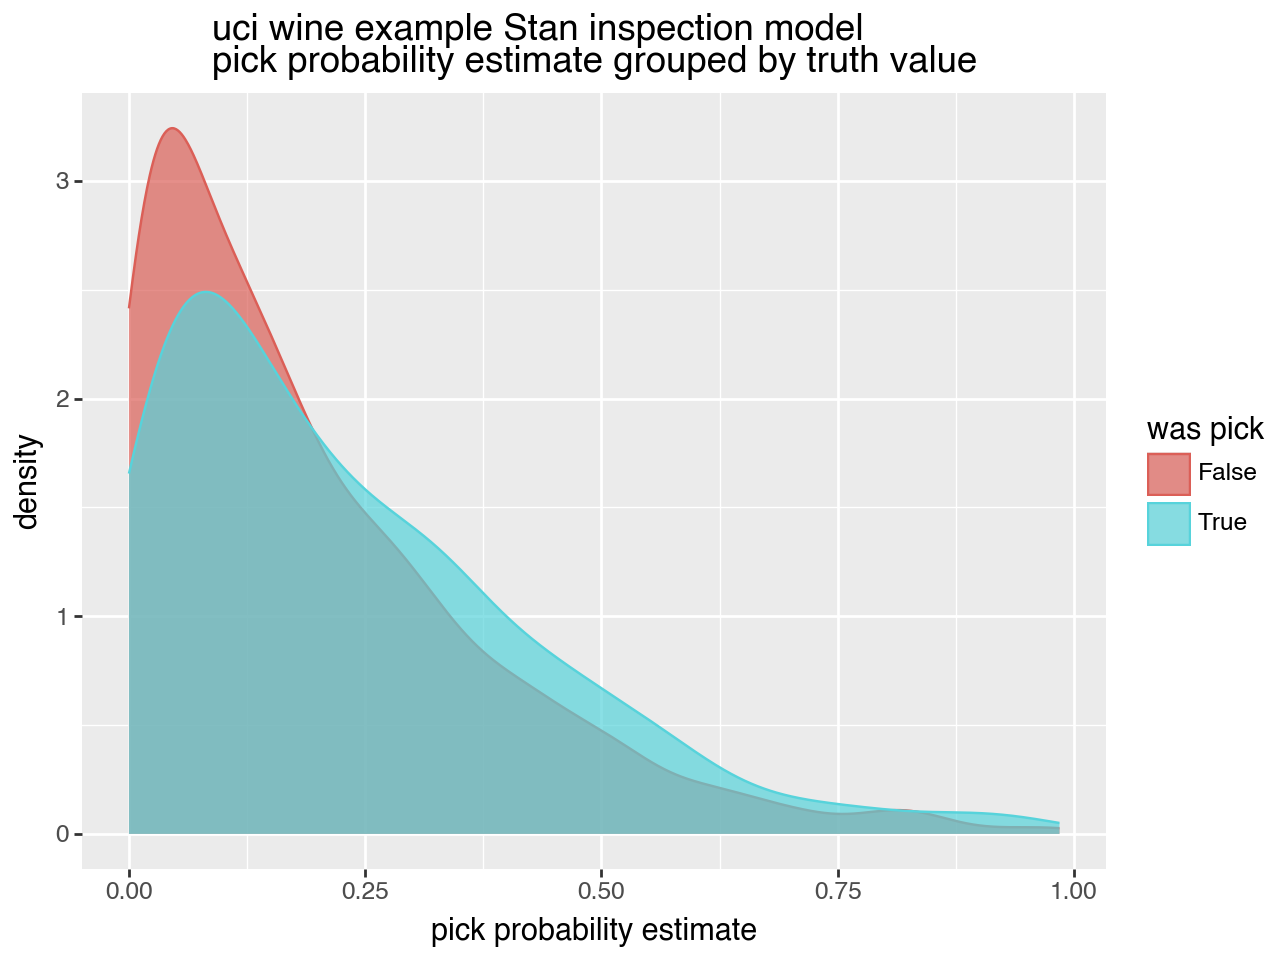

<Figure size 640x480 with 0 Axes>

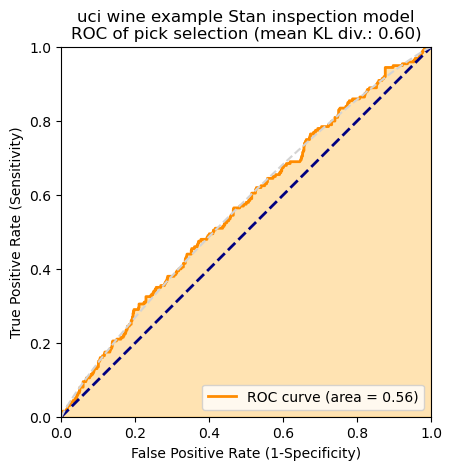

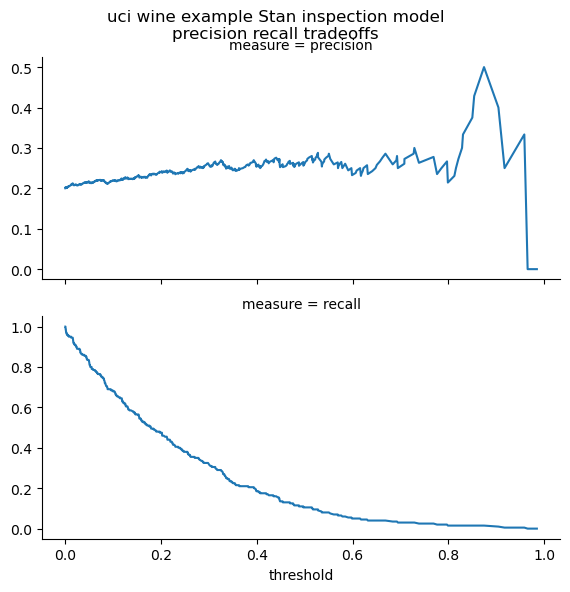

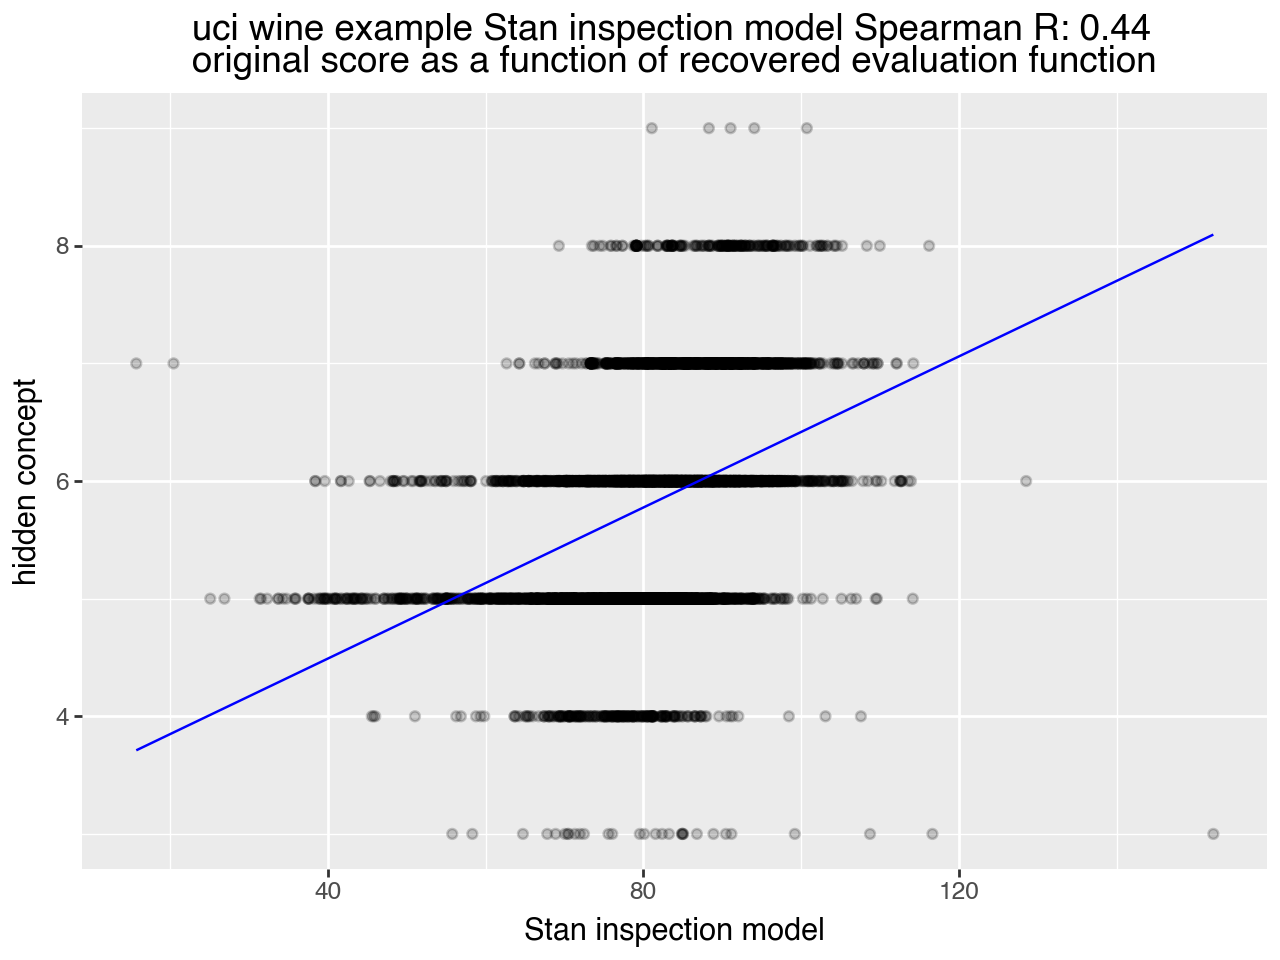

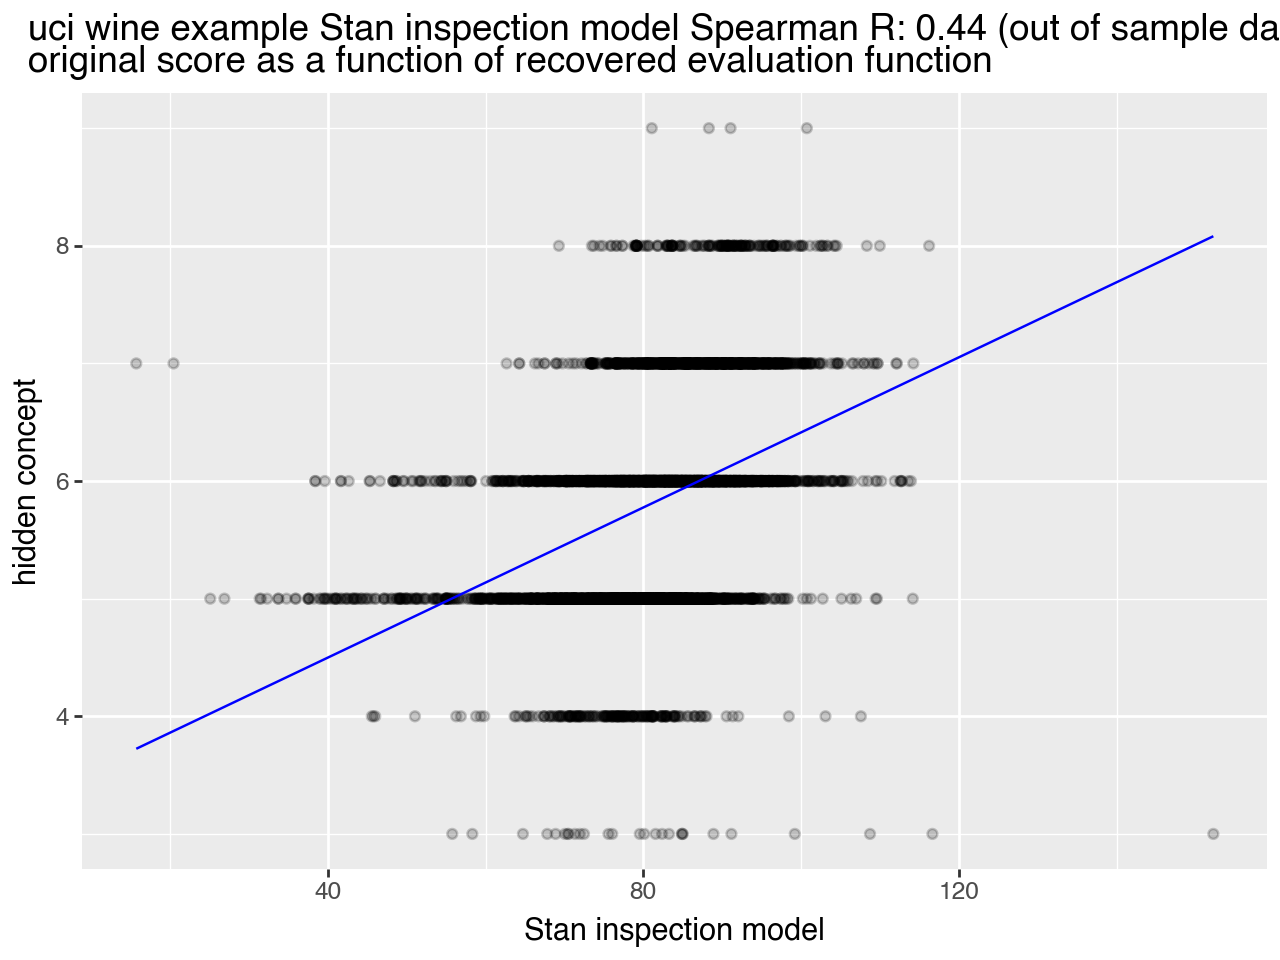

In [25]:
stat_pull_inspection_Stan = plot_rank_performance(
    model=estimated_beta_inspection_Stan,  # estimated coefficients
    model_type='coef',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of lists
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name="Stan inspection model",  # display name of estimate
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull_inspection_Stan)

Try a Stan model with position choice modeled as utility.

In [26]:
observations_sorted_train = sort_observations_frame(observations_train)

In [27]:
def run_sorted_Stan_model(
    *,
    stan_model_list_src: str,
    estimate_name: str,
):
    
    if do_display:
        print(stan_model_list_src)
    data_str = format_Stan_data(
        observations_sorted=observations_sorted_train,
        features_frame=features_frame,
    )
    fit_utility_Stan = run_stan_model(
        stan_model_src=stan_model_list_src,
        data_str=data_str,
        model_note=estimate_name,
        clean_up=clean_up,
        show_console=show_console,
    )
    beta_draws_utility = fit_utility_Stan.draws_pd(vars=["beta"])
    beta_draws_utility_display = beta_draws_utility.copy()
    beta_draws_utility_display.columns = list(features_frame.columns) + [
        f'position_{sel_j}' for sel_j in range(n_alternatives)
    ]
    # get implied sample weights from chain
    wt_frame_utility = fit_utility_Stan.draws_pd(vars=["lp__"])
    if do_display:
        stddev = np.sqrt(np.var(wt_frame_utility["lp__"]))
        log_samples = np.log(wt_frame_utility.shape[0])
        (
            ggplot(
                data=wt_frame_utility,
                mapping=aes(x="lp__"),
            )
            + geom_density(fill="gray", alpha=0.7)
            + ggtitle(
                f"{example_name} {estimate_name} draws\nstandard deviation: {stddev:.2f}, log samples = {log_samples:.2f}"
            )
        ).show()
    estimated_beta_utility_Stan = beta_draws_utility_display.loc[
        wt_frame_utility["lp__"] >= np.quantile(wt_frame_utility["lp__"], 0.5), :
    ].mean()
    stat_pull_Stan = plot_rank_performance(
        model=estimated_beta_utility_Stan,  # estimated coefficients
        model_type='coef',
        example_name=example_name,  # name of data set
        n_alternatives=n_alternatives,  # size of lists
        features_frame=features_frame,  # features by row id
        observations_train=observations_train,  # training observations layout frame
        observations_test=observations_test,  # evaluation observations layout frame
        estimate_name=estimate_name,  # display name of estimate
        score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
        rng=rng,  # pseudo random source
        show_plots=do_display,
    )
    collected_stats.append(stat_pull_Stan)


data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
  matrix[m_examples, n_vars] x_passed_1;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_2;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_3;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_4;   // character of passed examples
}
parameters {
  vector[n_vars] beta;                      // model parameters
  vector[m_examples] error_picked;          // reified noise term on picks (the secret sauce!)
}
transformed parameters {
  vector[m_examples] expect_picked;
  vector[m_examples] v_picked;
  vector[m_examples] expect_passed_1;
  vector[m_examples] expect_passed_2;
  vector[m_examples] expect_passed_3;
  vector[m_examples] expect_passed_4;
  expect_picked = x_picked * beta;          // mod

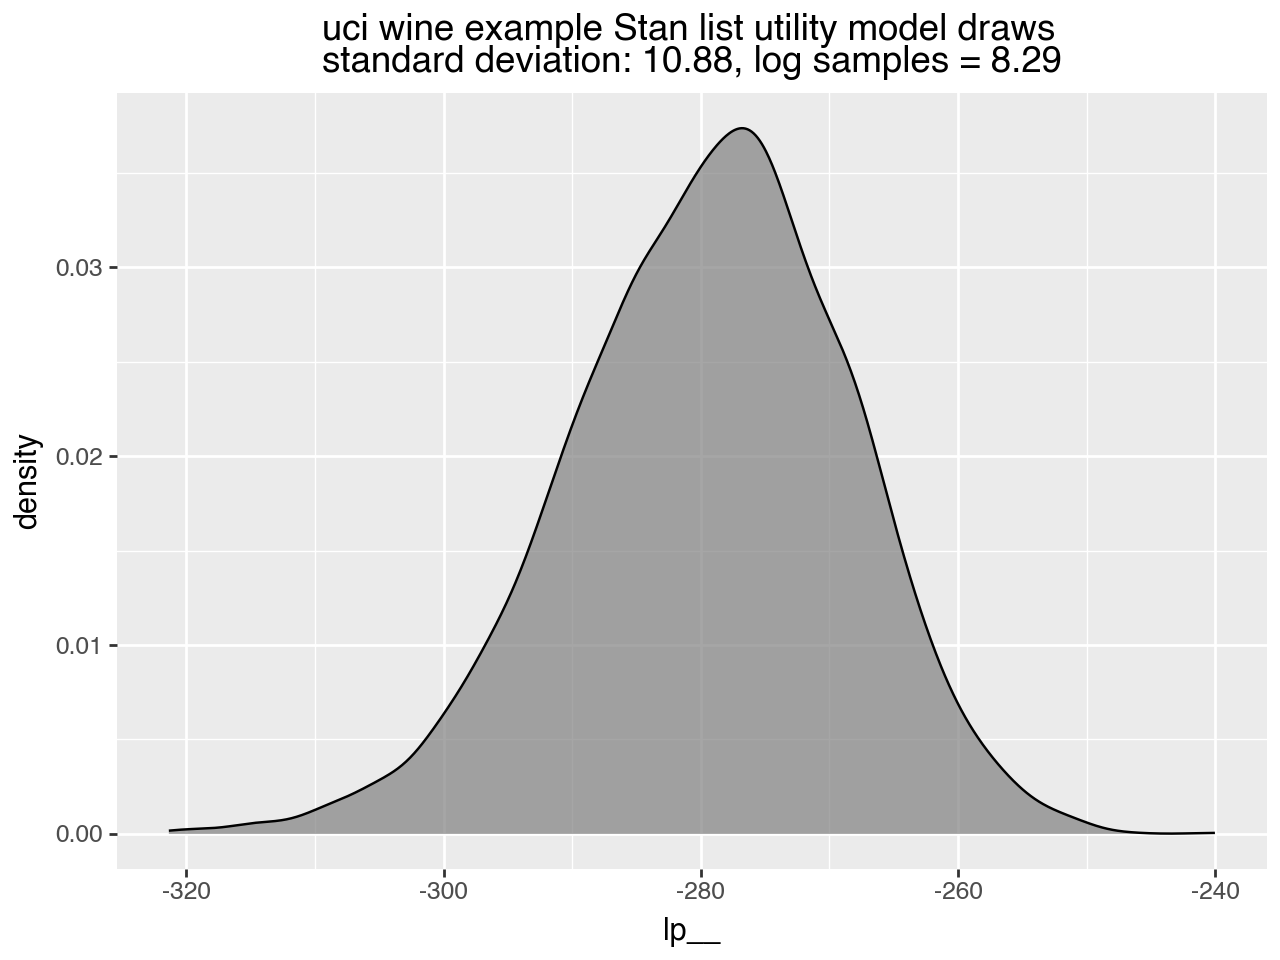

picks


,row,position,pick probability estimate,was pick
0,0,0,0.3287,False
1,0,1,0.3825,False
2,0,2,0.0655,False
3,0,3,0.1409,True
4,0,4,0.0824,False
5,1,0,0.3175,False
6,1,1,0.2291,False
7,1,2,0.0496,True
8,1,3,0.2312,False
9,1,4,0.1726,False


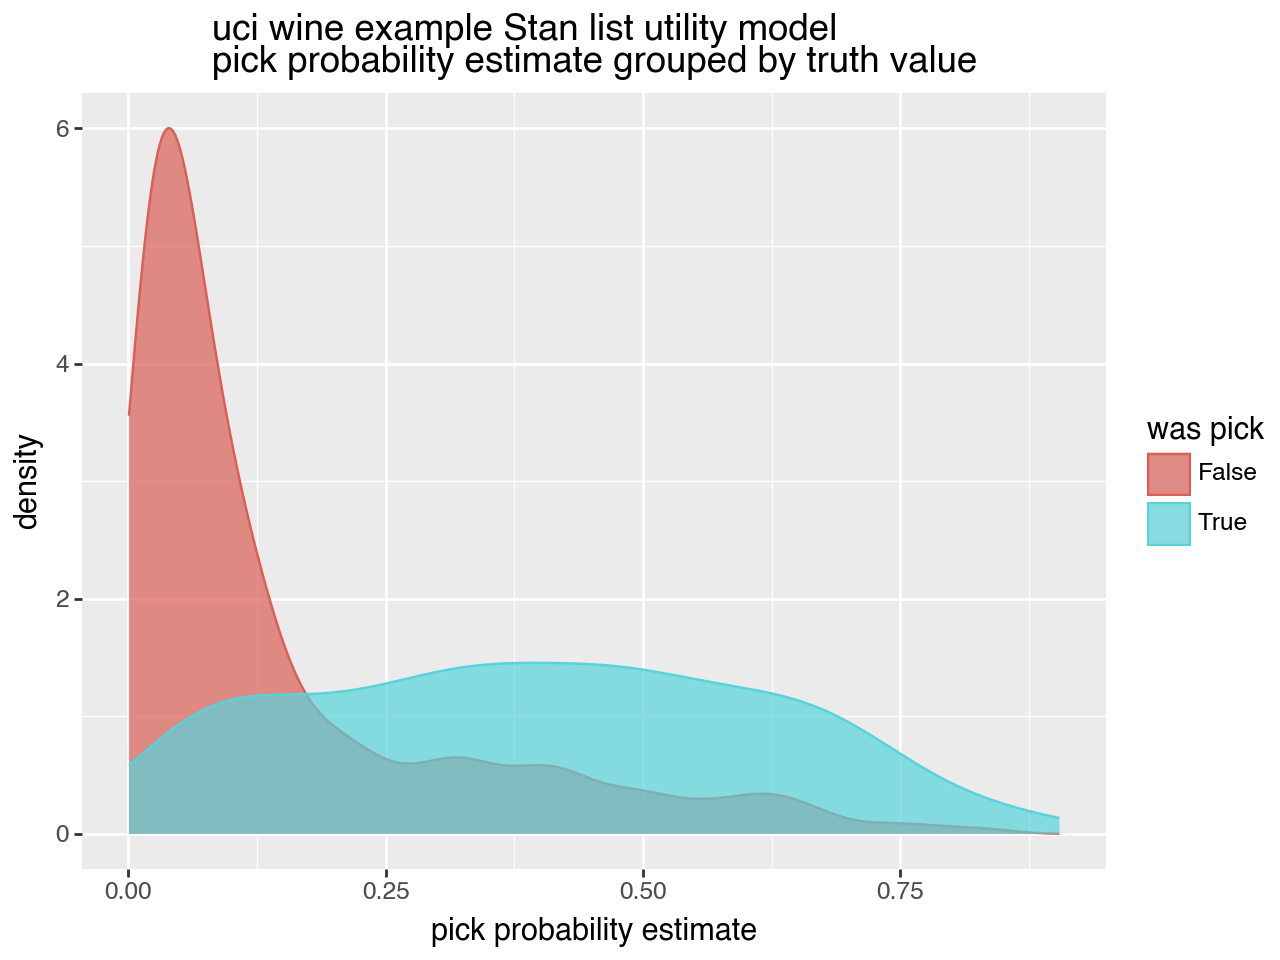

<Figure size 640x480 with 0 Axes>

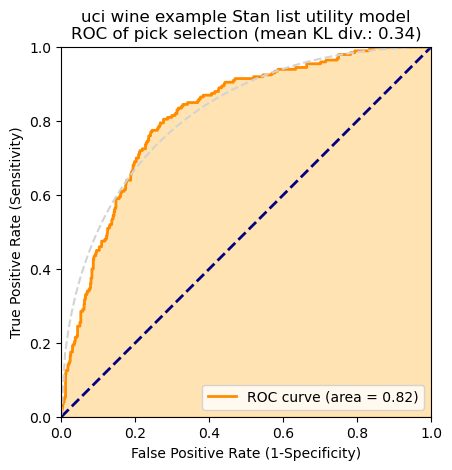

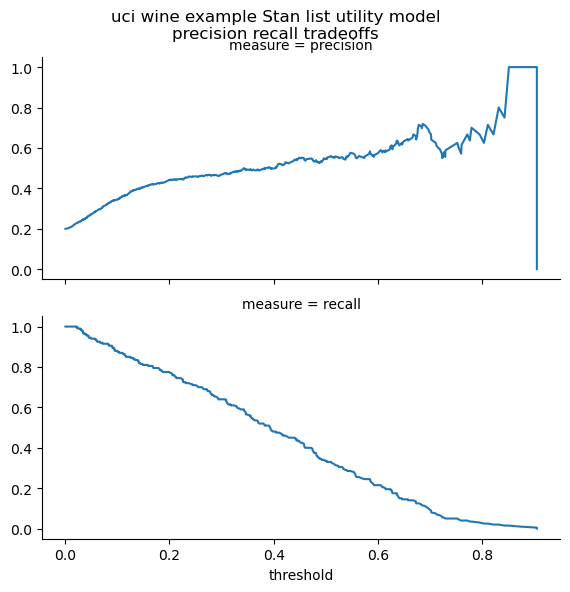

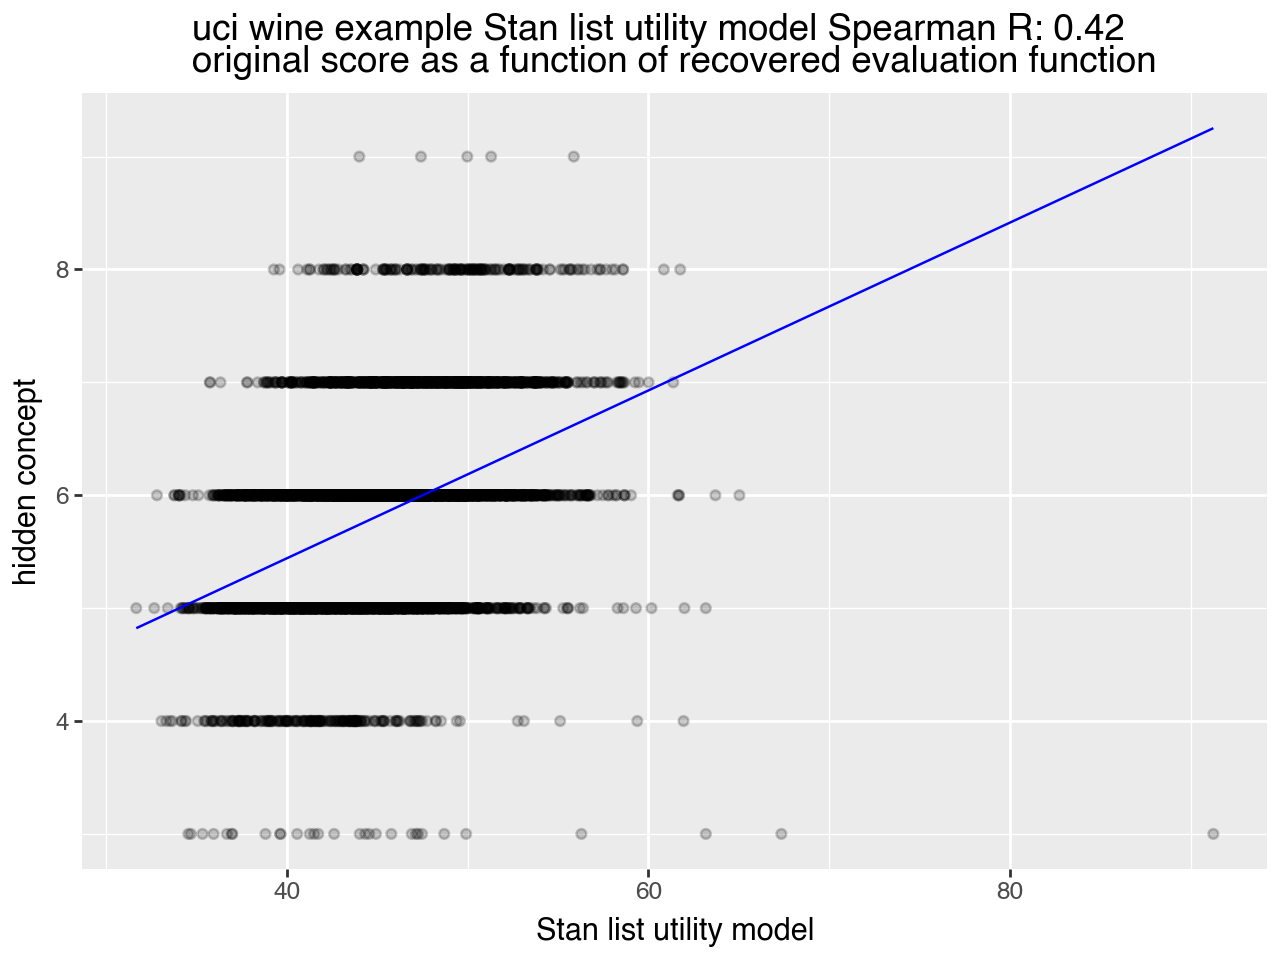

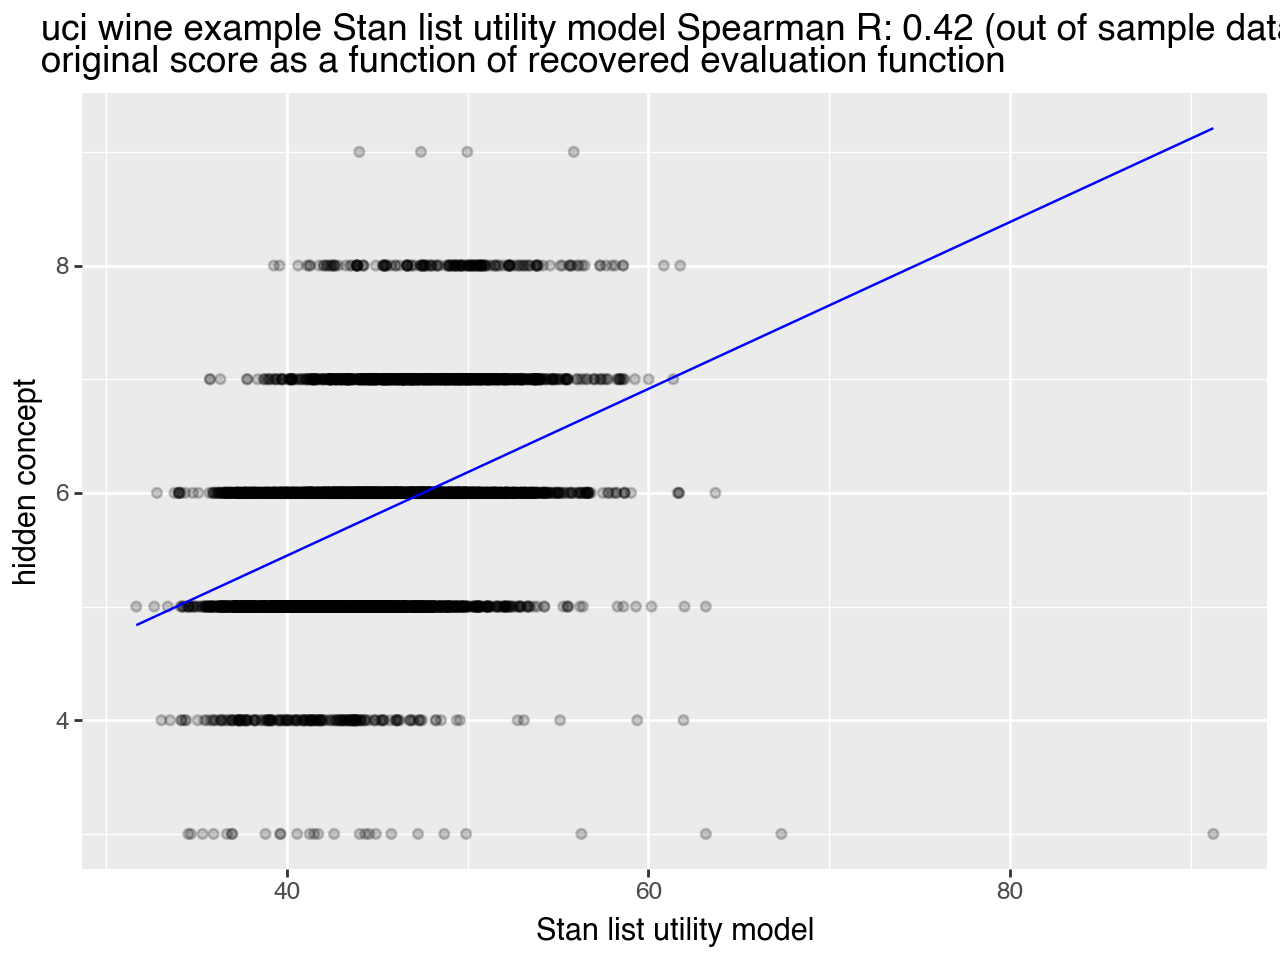

In [28]:
run_sorted_Stan_model(
    stan_model_list_src = define_Stan_list_src(n_alternatives=n_alternatives),
    estimate_name="Stan list utility model",
)


data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
  matrix[m_examples, n_vars] x_passed_1;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_2;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_3;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_4;   // character of passed examples
}
parameters {
  vector[n_vars] beta;                      // model parameters
}
transformed parameters {
  vector[m_examples] expect_picked;
  vector[m_examples] expect_passed_1;
  vector[m_examples] expect_passed_2;
  vector[m_examples] expect_passed_3;
  vector[m_examples] expect_passed_4;
  expect_picked = x_picked * beta;          // modeled expected score of picked item
  expect_passed_1 = x_passed_1 * beta;      // modeled expected score of passed item
  expe

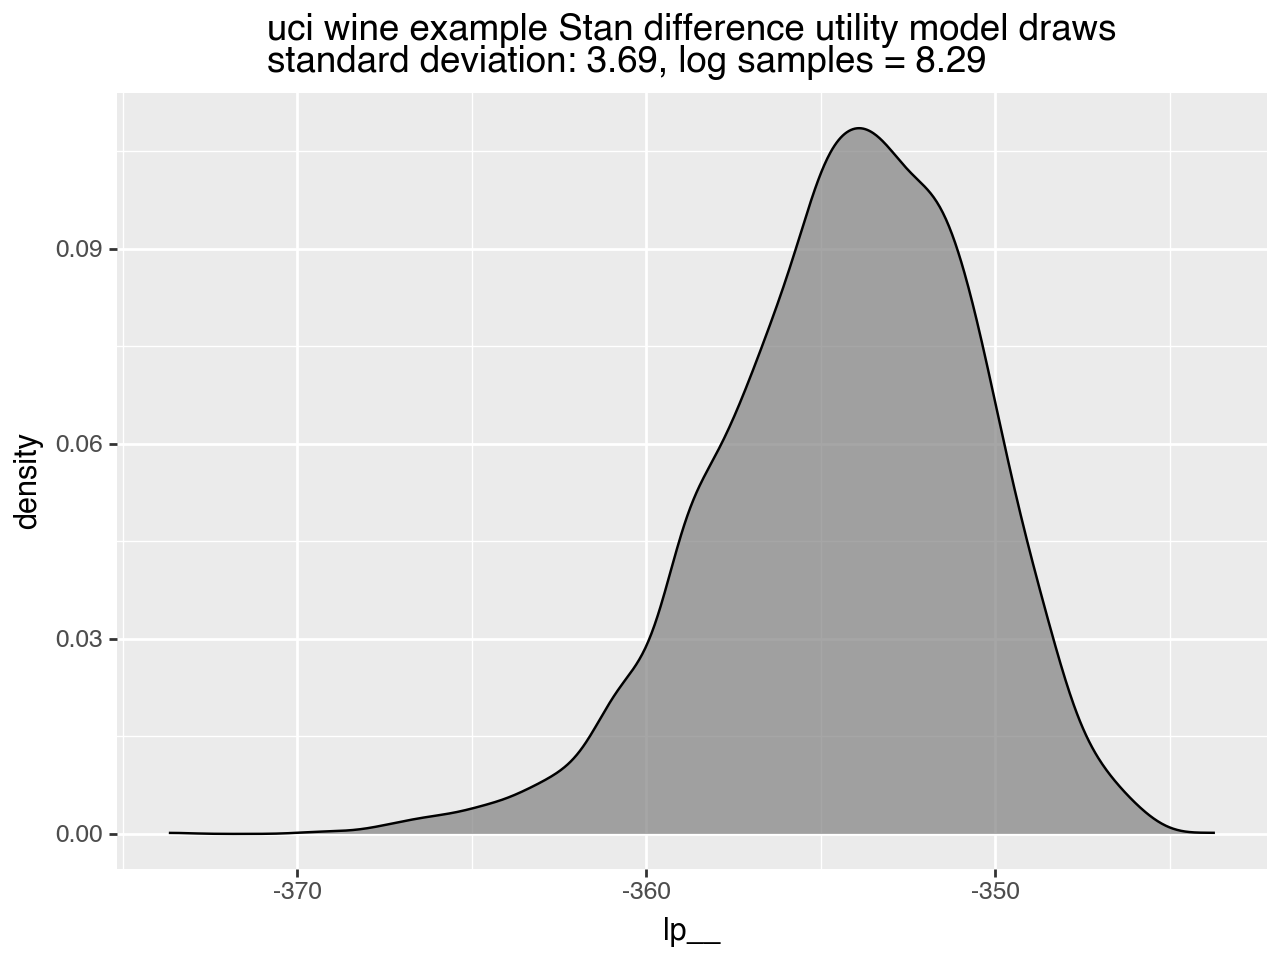

picks


,row,position,pick probability estimate,was pick
0,0,0,0.3550,False
1,0,1,0.4246,False
2,0,2,0.0495,False
3,0,3,0.1176,True
4,0,4,0.0533,False
5,1,0,0.3120,False
6,1,1,0.2772,False
7,1,2,0.0381,True
8,1,3,0.2012,False
9,1,4,0.1715,False


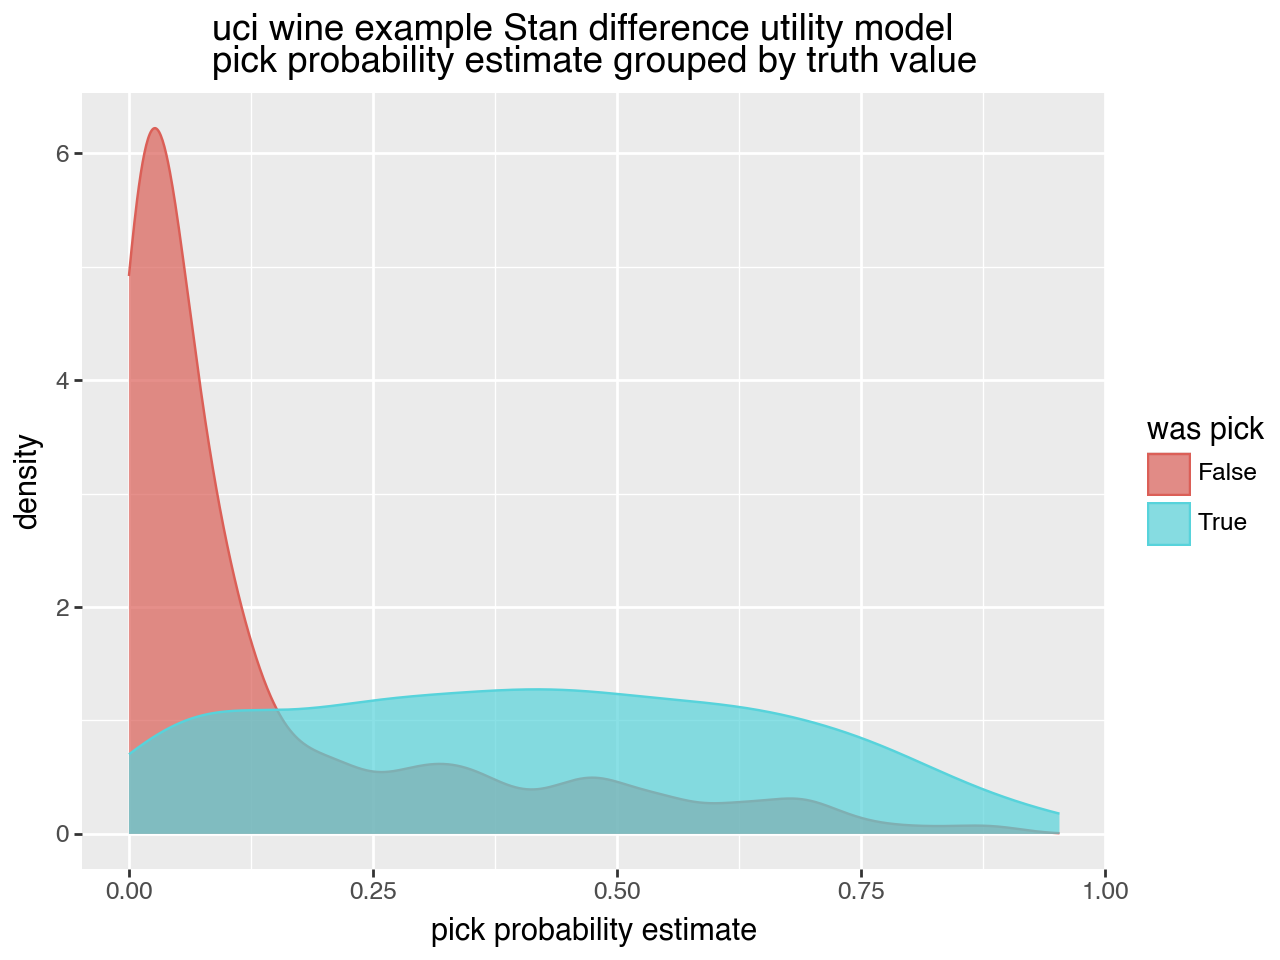

<Figure size 640x480 with 0 Axes>

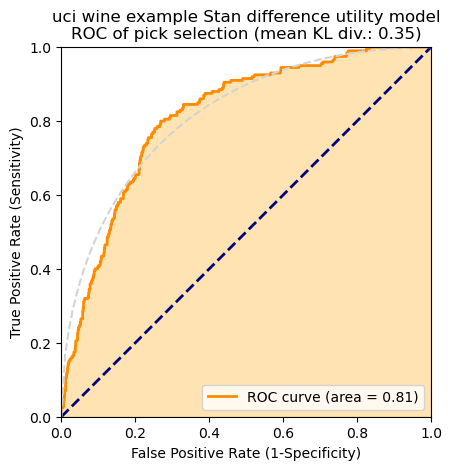

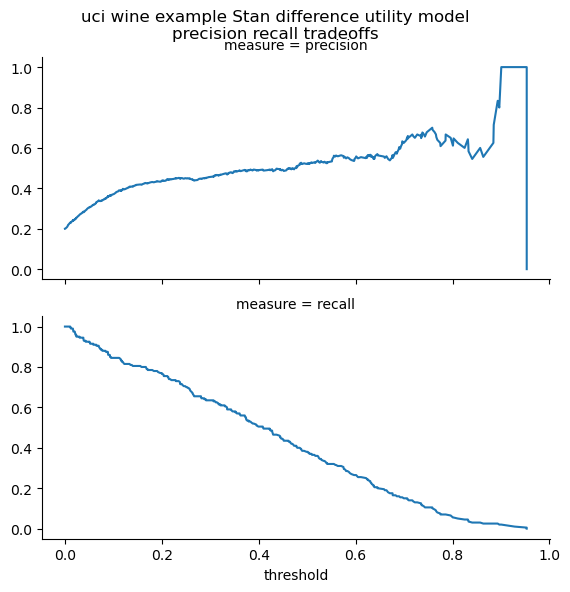

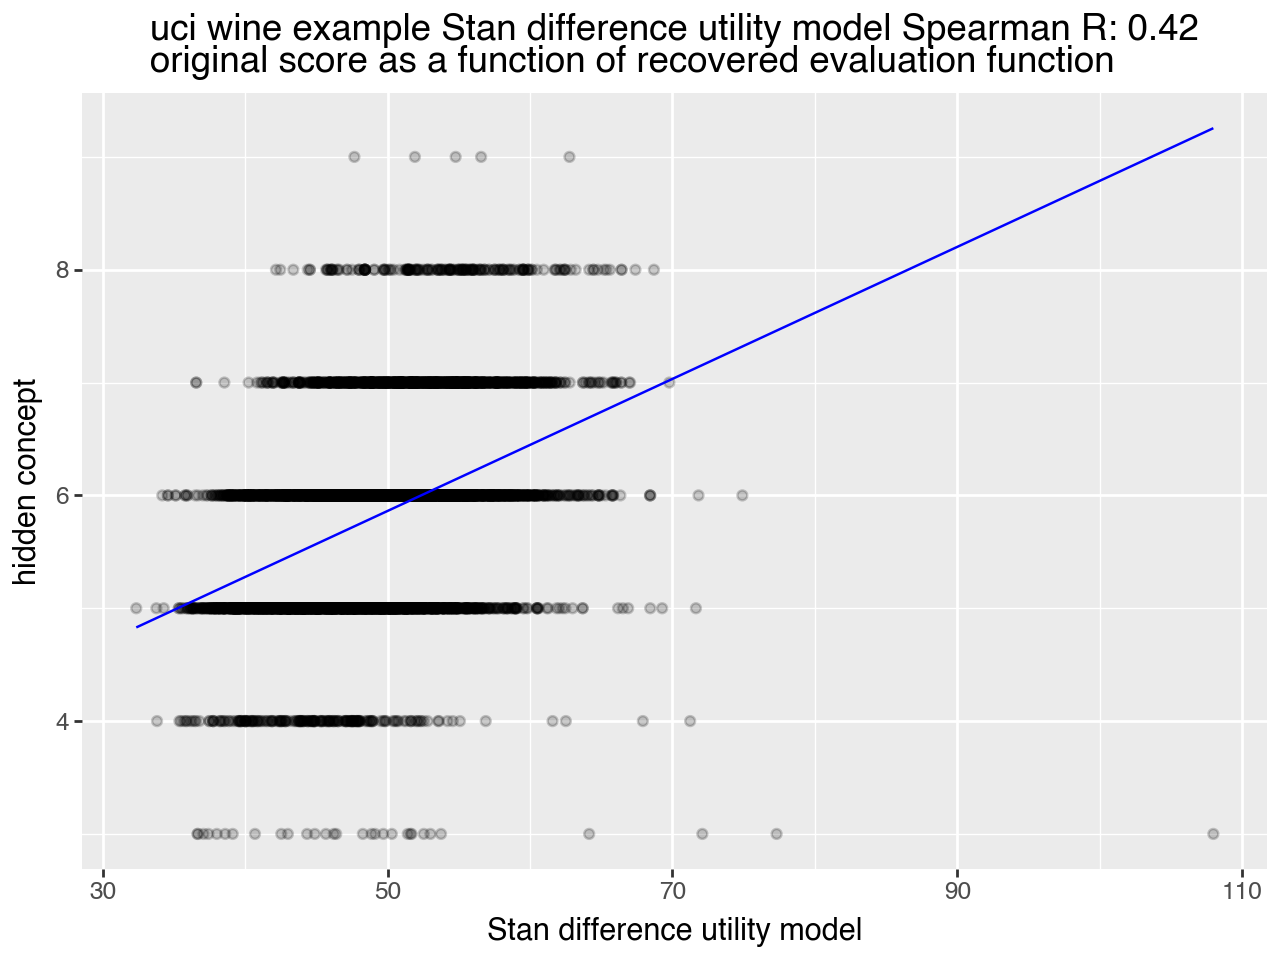

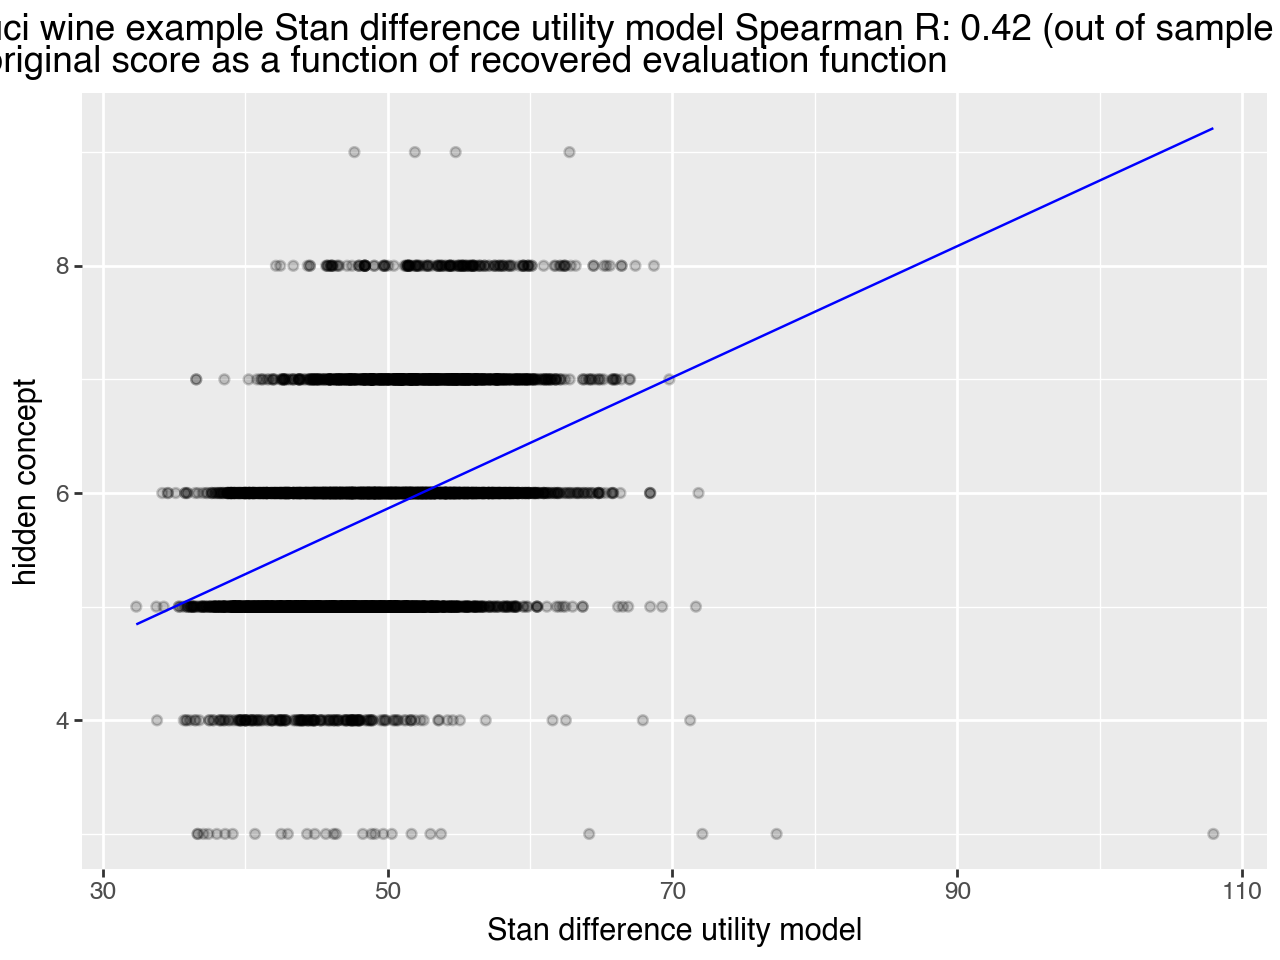

In [29]:
run_sorted_Stan_model(
    stan_model_list_src = define_Stan_choice_src(n_alternatives=n_alternatives),
    estimate_name="Stan difference utility model",
)

Try to approximate the Stan model with a classification model with similar error structure.
Consider each pair of list entries with a different outcome as an observation and try to
build a model that reproduces the observed outcomes.
The extra trick is: repeat the whole data frame negated with the outcomes reverse (so 
we don't define a problem with all positive or all negative outcomes).


In [30]:
def fit_logistic_differences(
    *,
    early_stop: bool,
) -> None:
    feature_names = list(features_frame.columns) + [
        f"position_{sel_i}" for sel_i in range(n_alternatives)
    ]
    difference_enc_frame = []
    for row_i in range(observations_train.shape[0]):
        feature_row = observations_train.loc[row_i, :]
        sel_pick = np.argmax(
            feature_row[[f"pick_value_{sel_i}" for sel_i in range(n_alternatives)]]
        )
        range_stop = n_alternatives
        if early_stop:
            range_stop = sel_pick + 1
        for sel_i in range(range_stop):
            if sel_i != sel_pick:
                posn_vec = [0] * n_alternatives
                posn_vec[sel_pick] = 1.0
                posn_vec[sel_i] = -1.0
                encoded_row = list(
                        features_frame.loc[feature_row[f"item_id_{sel_pick}"], :]
                        - features_frame.loc[feature_row[f"item_id_{sel_i}"], :]
                    ) + posn_vec  
                di = pd.DataFrame({k: [v] for k, v in zip(feature_names, encoded_row)})
                difference_enc_frame.append(di)
    difference_enc_frame = pd.concat(difference_enc_frame, ignore_index=True)
    classification_model_differences = LogisticRegression(max_iter=10000, solver="newton-cholesky")
    classification_model_differences.fit(
        X=pd.concat([difference_enc_frame, -difference_enc_frame], ignore_index=True),
        y=[True] * difference_enc_frame.shape[0] + [False] * difference_enc_frame.shape[0],
    )
    stat_pull_classifier_differences = plot_rank_performance(
        model=classification_model_differences,
        model_type='classifier',
        example_name=example_name,  # name of data set
        n_alternatives=n_alternatives,  # size of lists
        features_frame=features_frame,  # features by row id
        observations_train=observations_train,  # training observations layout frame
        observations_test=observations_test,  # evaluation observations layout frame
        estimate_name=f'logistic differences, early stop={str(early_stop)[0]}',  # display name of estimate
        score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
        rng=rng,  # pseudo random source
        show_plots=do_display,
    )
    collected_stats.append(stat_pull_classifier_differences)

picks


,row,position,pick probability estimate,was pick
0,0,0,0.0909,False
1,0,1,0.1548,False
2,0,2,0.1984,False
3,0,3,0.2680,True
4,0,4,0.2879,False
5,1,0,0.0354,False
6,1,1,0.1639,False
7,1,2,0.2047,True
8,1,3,0.2446,False
9,1,4,0.3514,False


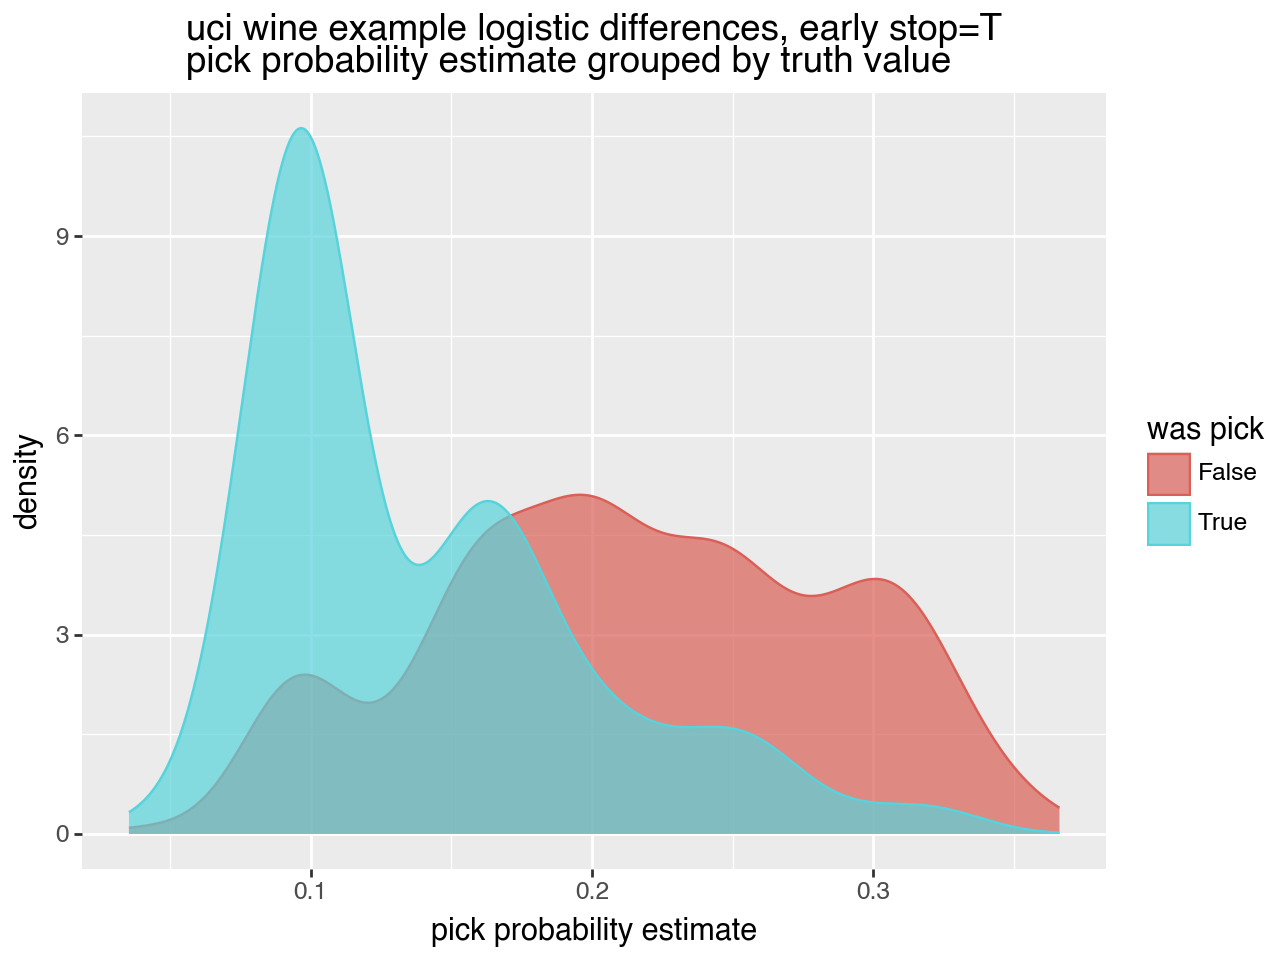

<Figure size 640x480 with 0 Axes>

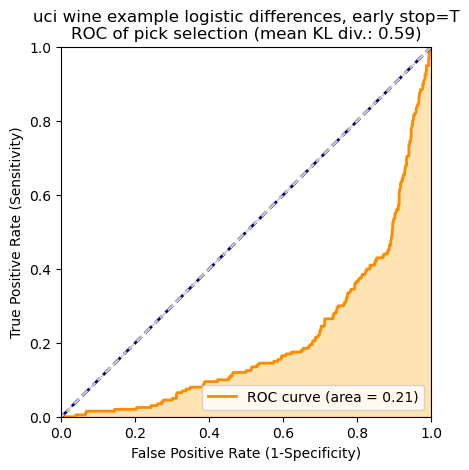

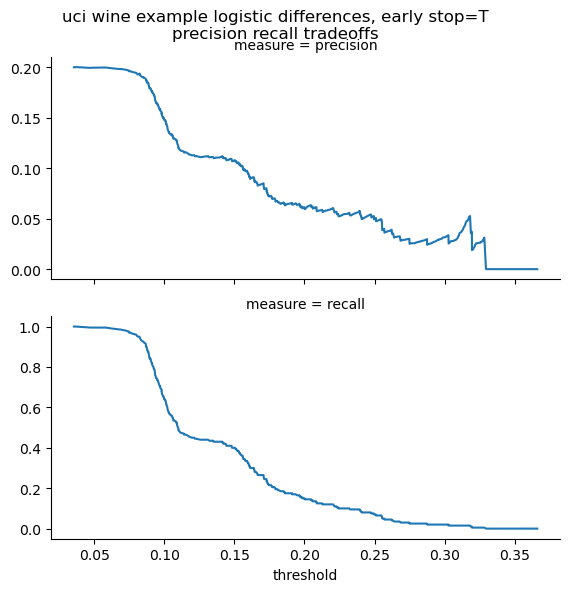

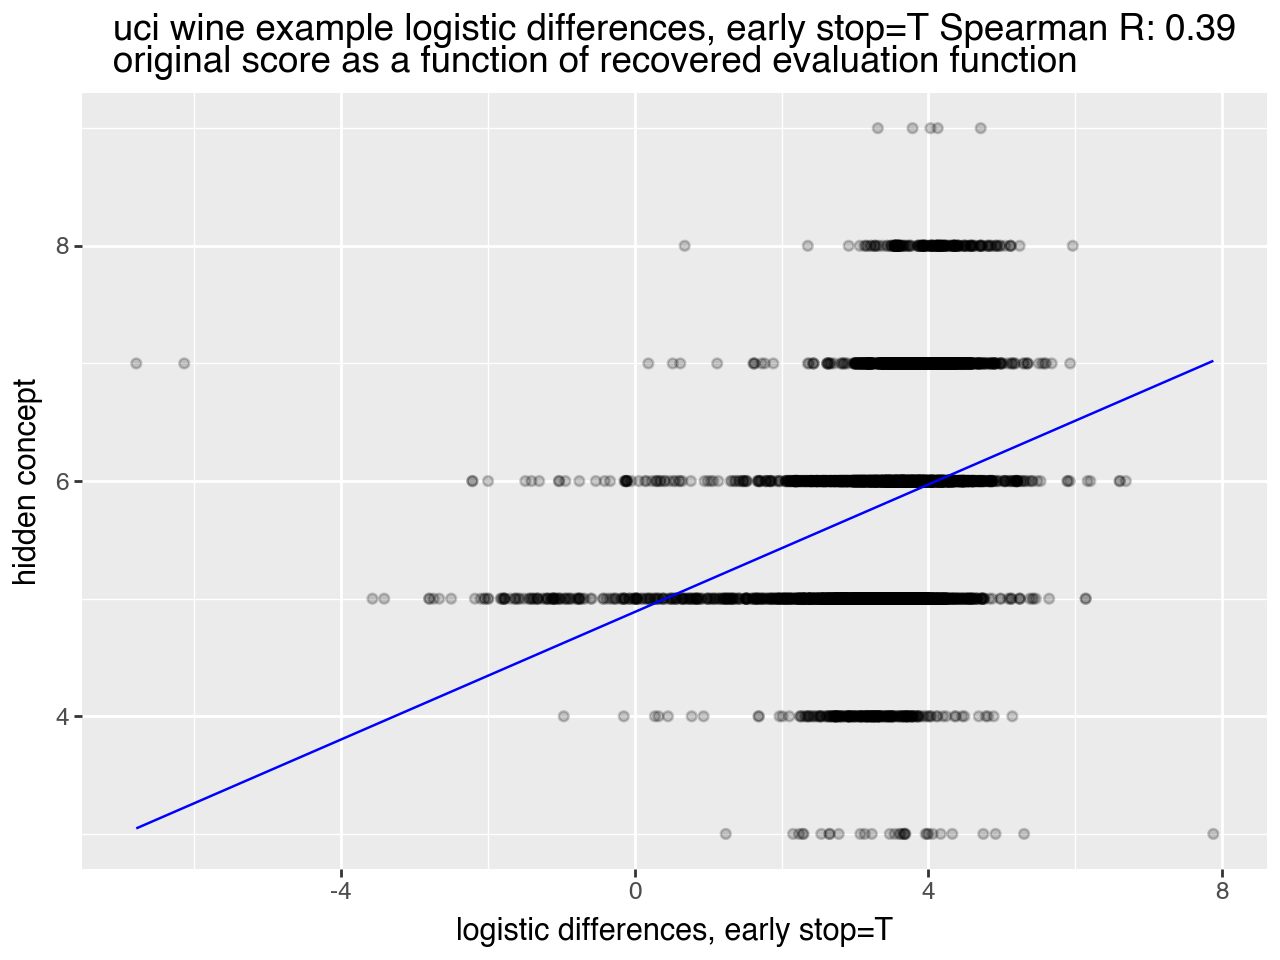

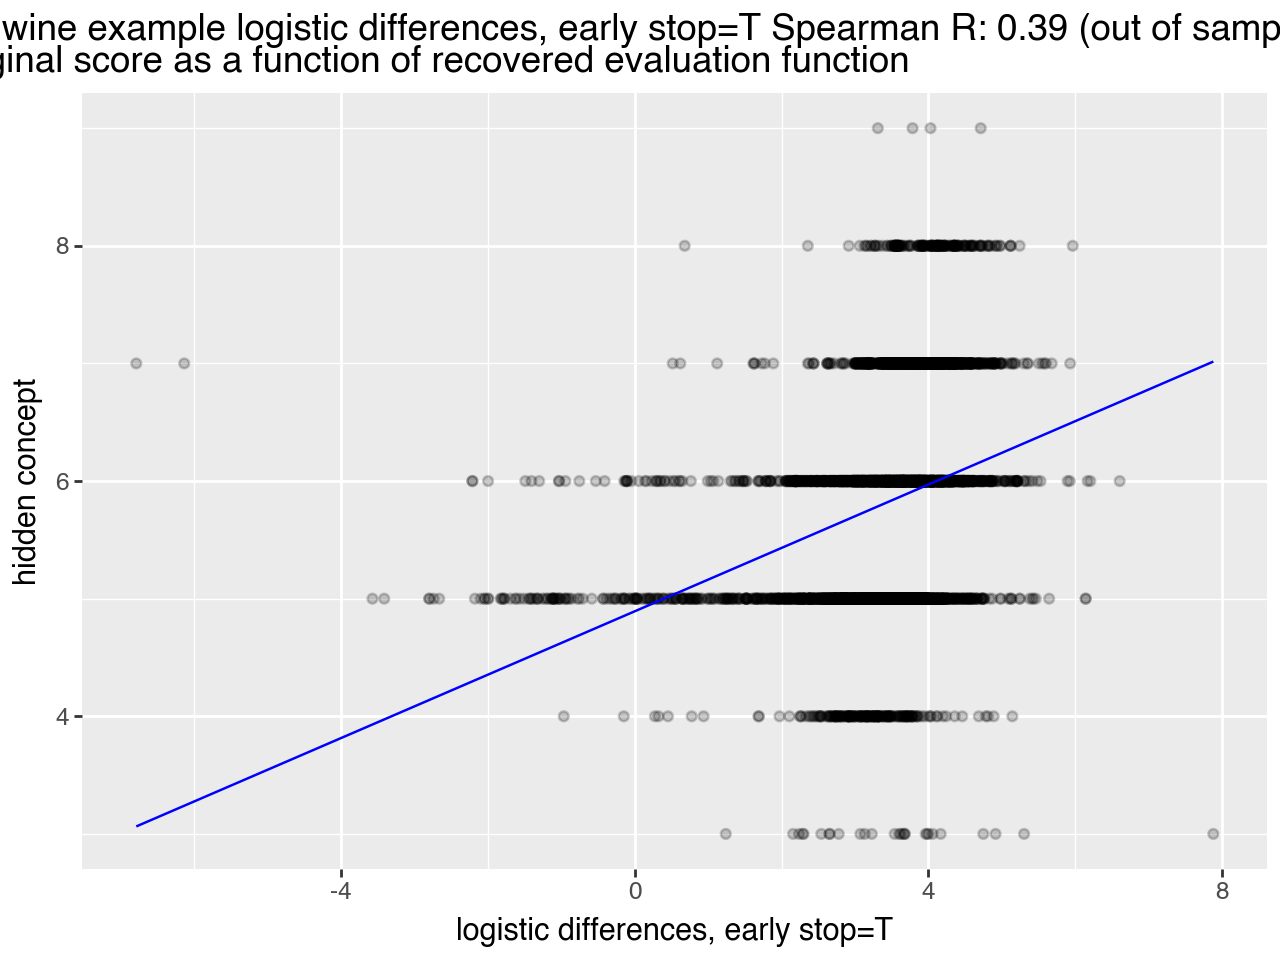

picks


,row,position,pick probability estimate,was pick
0,0,0,0.2180,False
1,0,1,0.2253,False
2,0,2,0.1765,False
3,0,3,0.1993,True
4,0,4,0.1809,False
5,1,0,0.2129,False
6,1,1,0.2063,False
7,1,2,0.1790,True
8,1,3,0.2022,False
9,1,4,0.1996,False


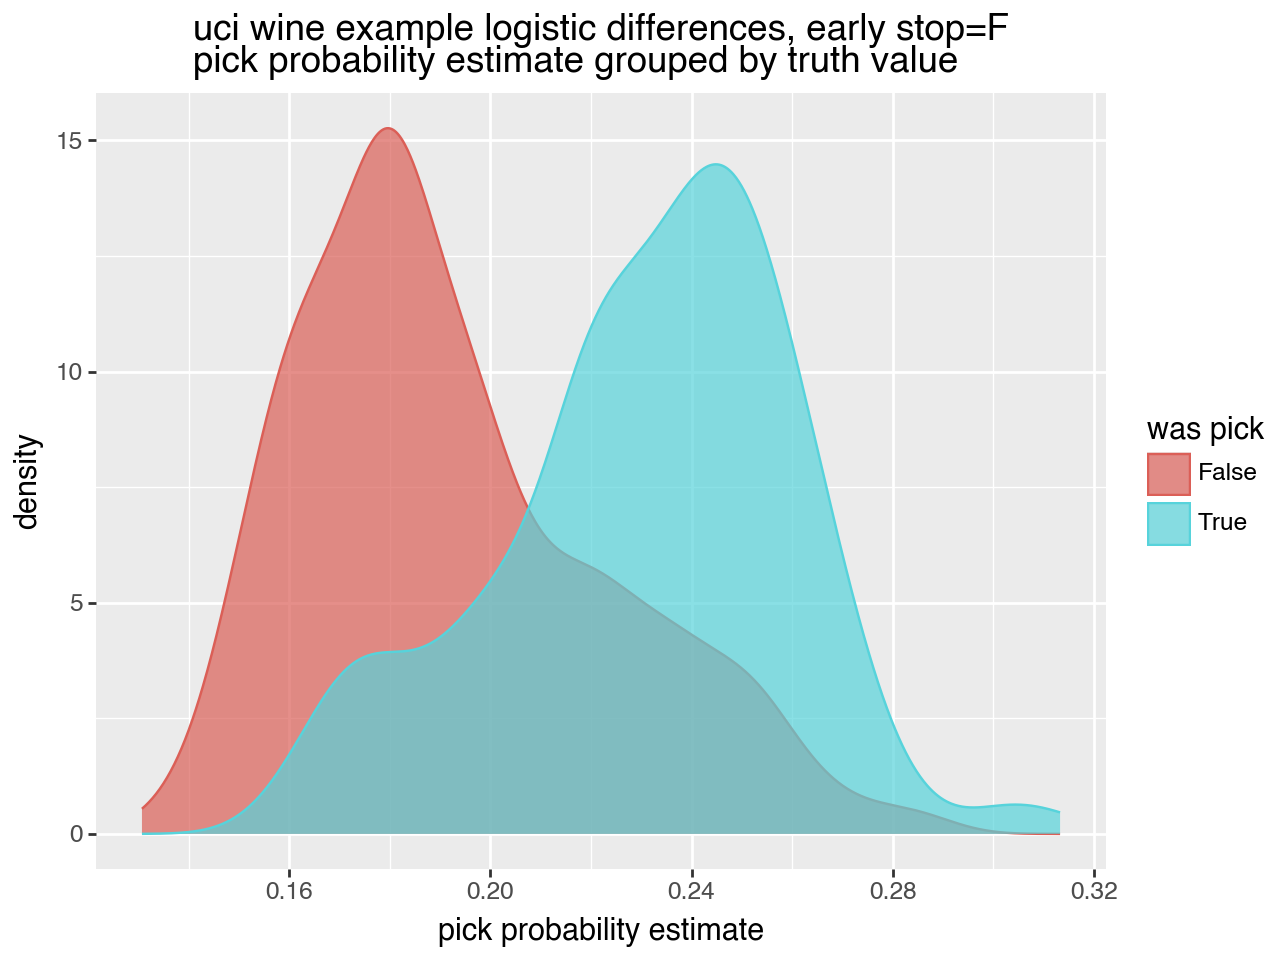

<Figure size 640x480 with 0 Axes>

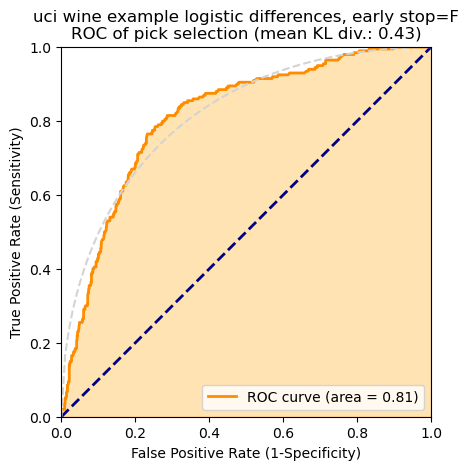

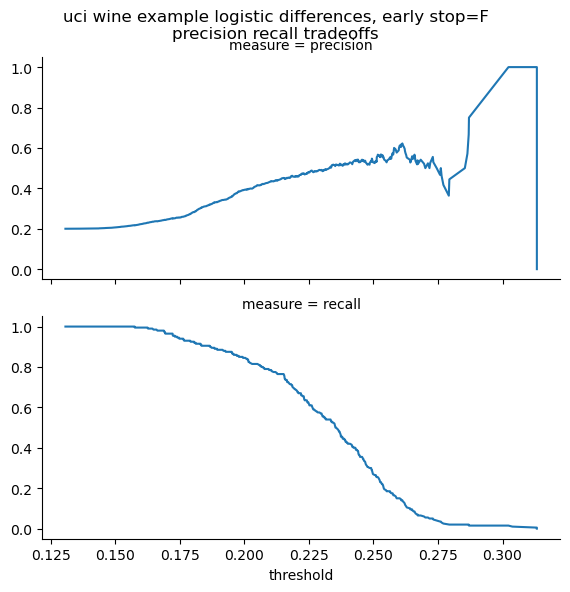

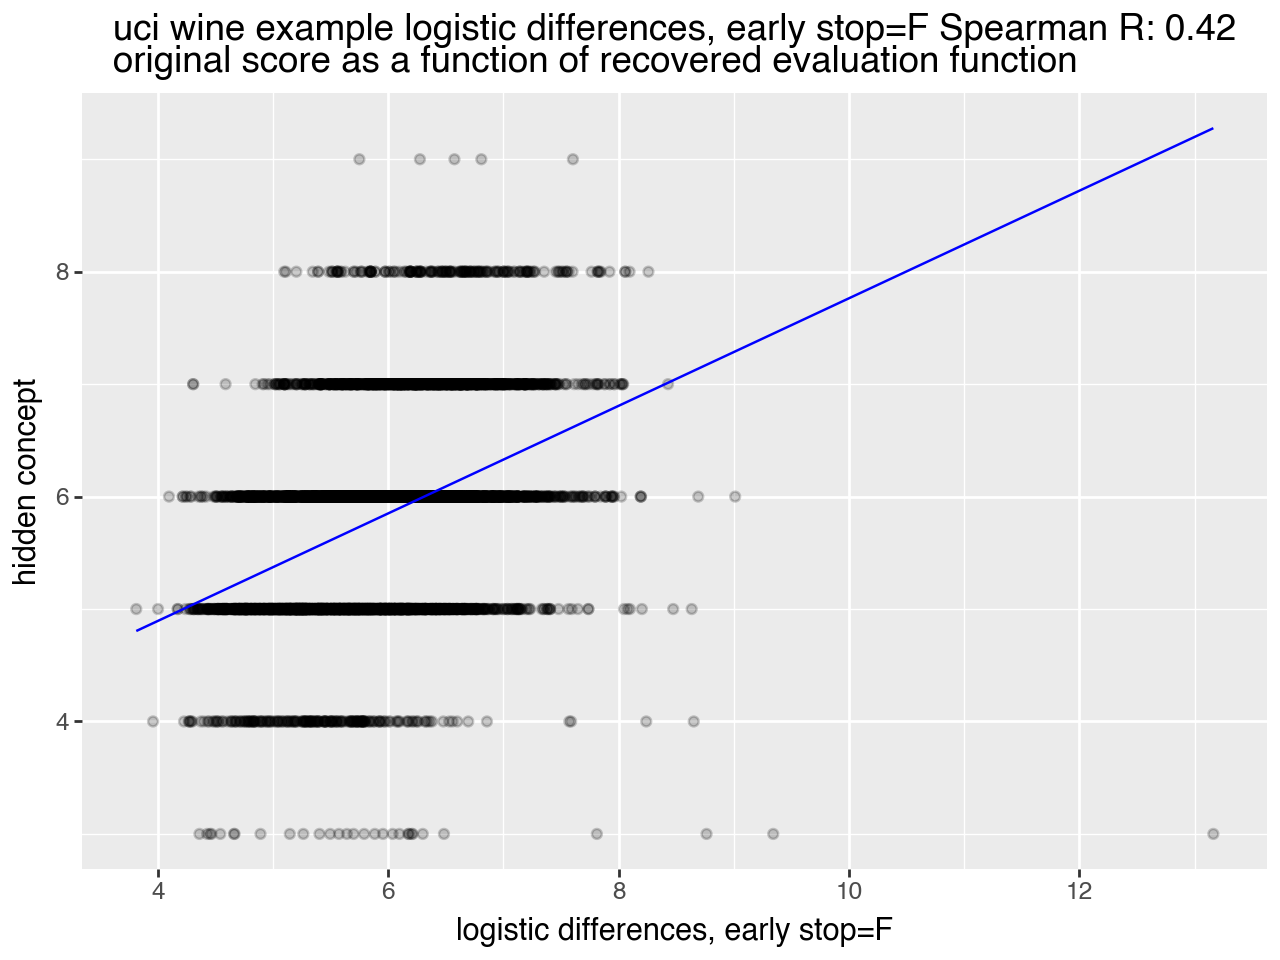

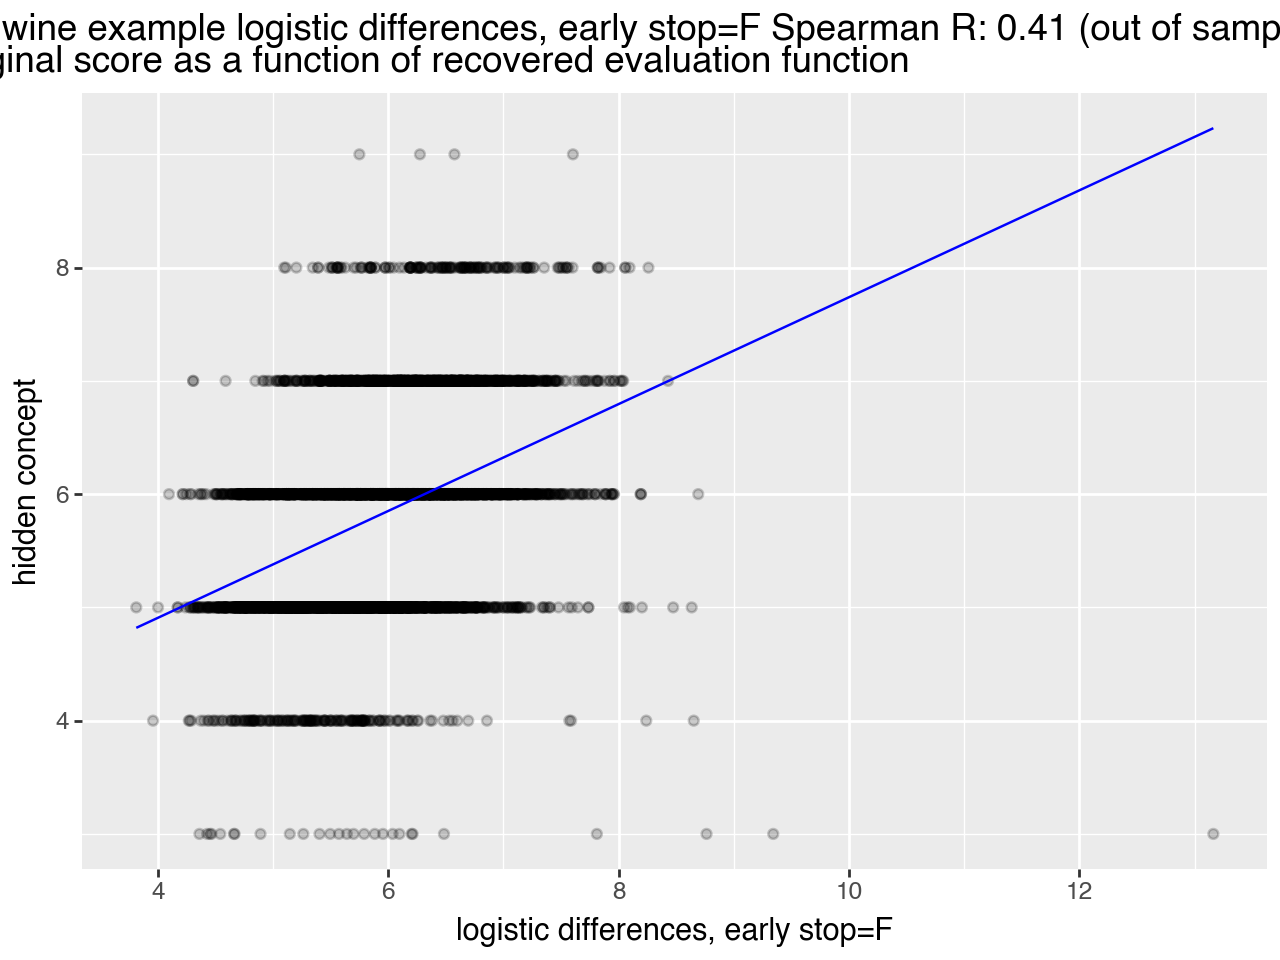

In [31]:

for early_stop in [True, False]:
    fit_logistic_differences(early_stop=early_stop)

Trying a model on directly on single items.

In [32]:
def fit_logistic_items() -> None:
    # encode items (with position)
    feature_names = list(features_frame.columns) + [
            f"position_{sel_i}" for sel_i in range(n_alternatives)
    ]
    item_enc_frame = []
    item_outcomes = []
    for row_i in range(observations_train.shape[0]):
        feature_row = observations_train.loc[row_i, :]
        sel_pick = np.argmax(
            feature_row[[f"pick_value_{sel_i}" for sel_i in range(n_alternatives)]]
        )
        for sel_i in range(n_alternatives):
            posn_vec = [0] * n_alternatives
            posn_vec[sel_i] = 1.0
            encoded_row = list(
                    features_frame.loc[feature_row[f"item_id_{sel_i}"], :]
                ) + posn_vec
            ri = pd.DataFrame({k: [v] for k, v in zip(feature_names, encoded_row)})
            item_enc_frame.append(ri)
            item_outcomes.append(sel_i == sel_pick)
    item_enc_frame = pd.concat(item_enc_frame, ignore_index=True)
    classification_model_items = LogisticRegression(max_iter=10000, solver="newton-cholesky")
    classification_model_items.fit(
        X=item_enc_frame,
        y=item_outcomes,
    )
    stat_pull_items_classifier = plot_rank_performance(
        model=classification_model_items,
        model_type='classifier',
        example_name=example_name,  # name of data set
        n_alternatives=n_alternatives,  # size of lists
        features_frame=features_frame,  # features by row id
        observations_train=observations_train,  # training observations layout frame
        observations_test=observations_test,  # evaluation observations layout frame
        estimate_name='logistic items',  # display name of estimate
        score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
        rng=rng,  # pseudo random source
        show_plots=False,
    )
    collected_stats.append(stat_pull_items_classifier)

In [33]:

fit_logistic_items()

We can compare this to just looking at the scores (not implementable in real world problems).

picks


,row,position,pick probability estimate,was pick
0,0,0,0.1754,False
1,0,1,0.2142,False
2,0,2,0.1858,False
3,0,3,0.2143,True
4,0,4,0.2103,False
5,1,0,0.1672,False
6,1,1,0.2031,False
7,1,2,0.1773,True
8,1,3,0.2141,False
9,1,4,0.2383,False


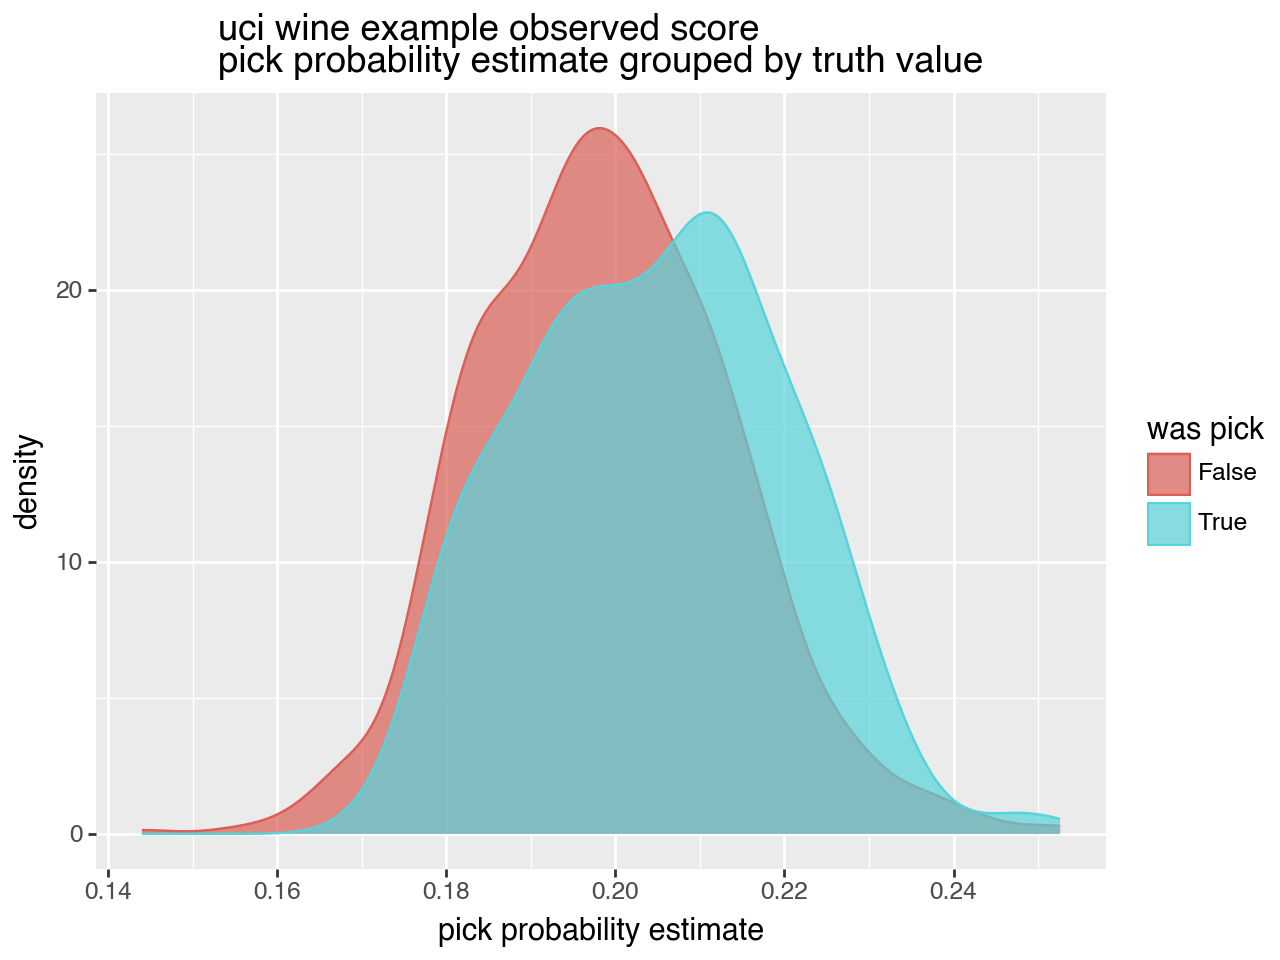

<Figure size 640x480 with 0 Axes>

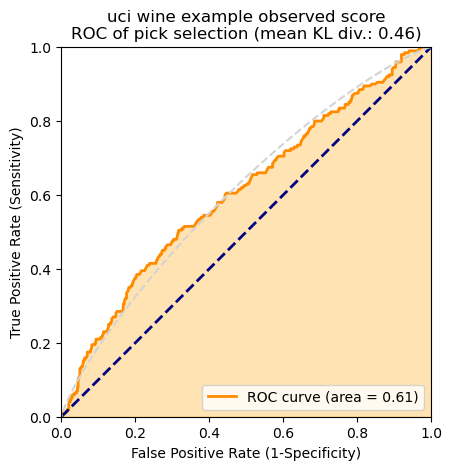

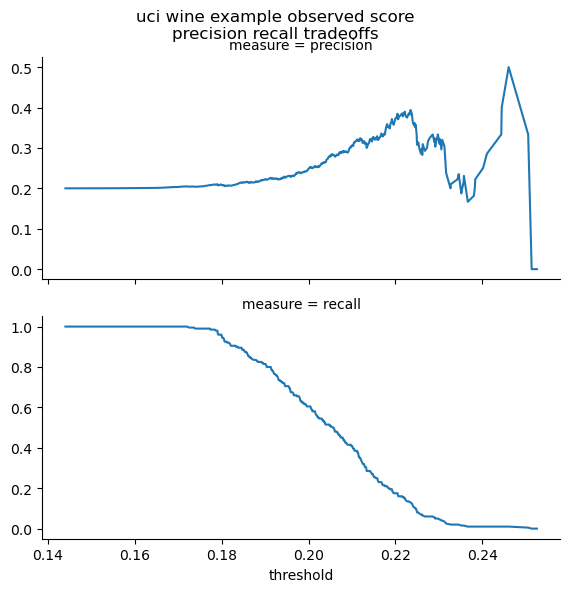

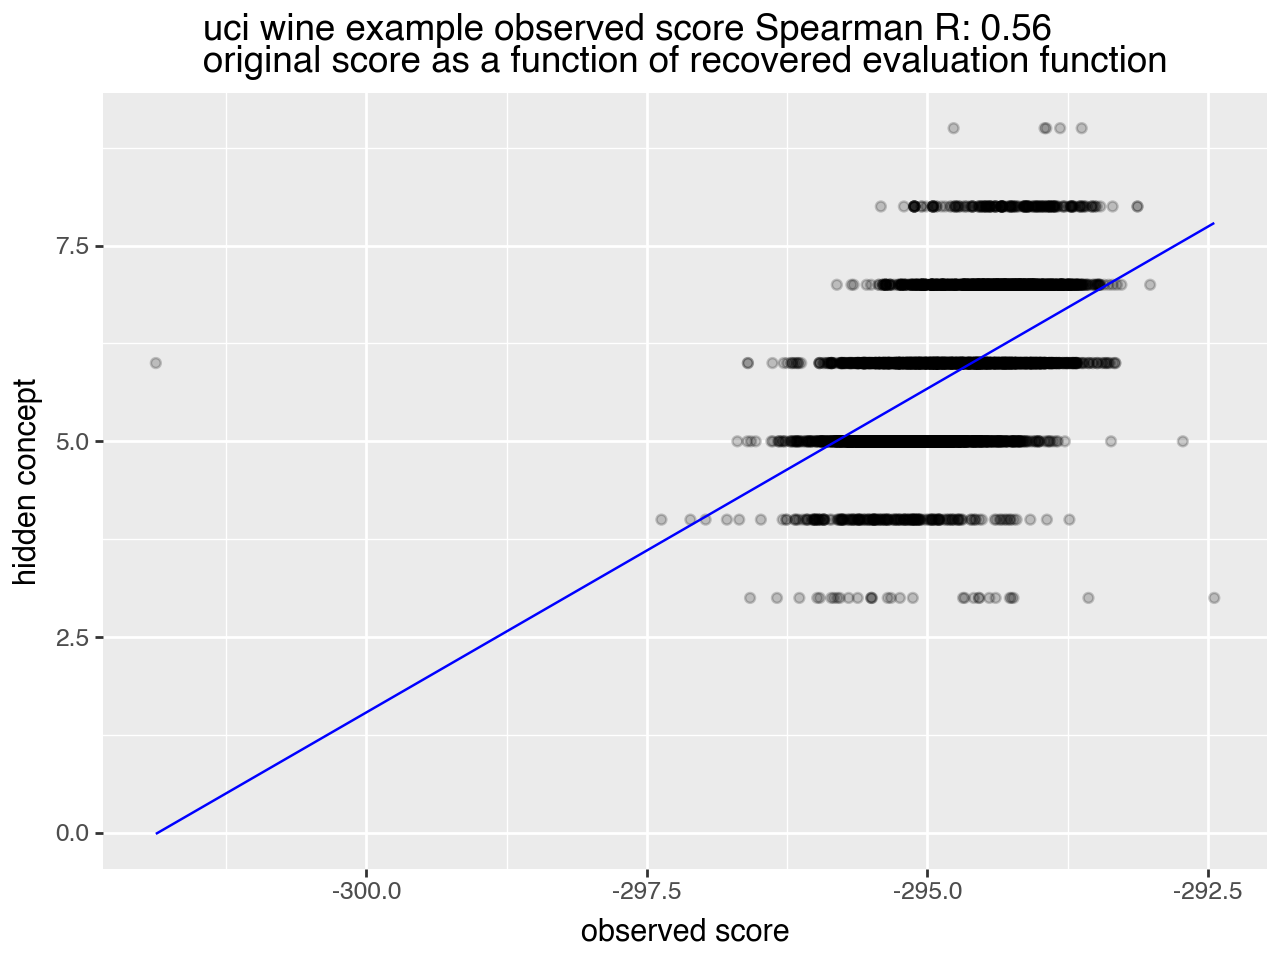

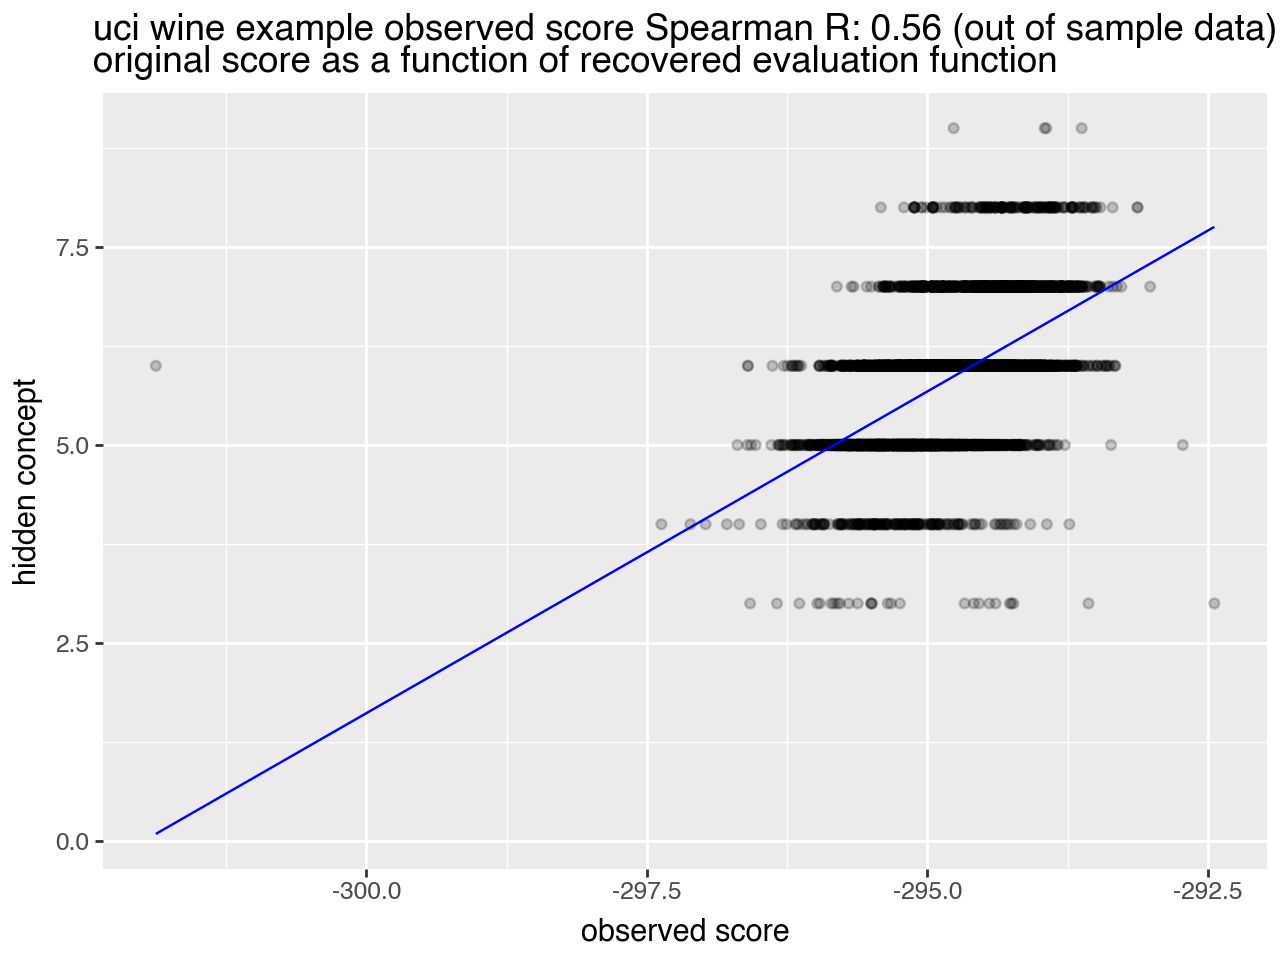

In [34]:
# plug in the perfect model that saw the scores
if know_score and (perfect_coef is not None):
    perfect_pull = plot_rank_performance(
        model=perfect_coef,  # estimated coefficients
        model_type='coef',  # TODO pass regression model directly
        example_name=example_name,  # name of data set
        n_alternatives=n_alternatives,  # size of lists
        features_frame=features_frame,  # features by row id
        observations_train=observations_train,  # training observations layout frame
        observations_test=observations_test,  # evaluation observations layout frame
        estimate_name="observed score",  # display name of estimate
        score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
        rng=rng,  # pseudo random source
        show_plots=do_display,
    )
    collected_stats.append(perfect_pull)

In [35]:
collected_stats = pd.concat(collected_stats, ignore_index=True)


In [36]:
if (result_fname is not None) and (len(result_fname) > 0):
    collected_stats.to_csv(result_fname, index=False)

In [37]:
if do_display:
    display(collected_stats)

,example_name,estimate_name,SpearmanR_all,SpearmanR_test,pick_auc,mean pick KL divergence,training lists,test lists,data_size,test_size
0,uci wine example,Stan inspection model,0.436398,0.435150,0.563012,0.596107,200,200,6497,5575
1,uci wine example,Stan list utility model,0.424685,0.423389,0.817434,0.340884,200,200,6497,5575
2,uci wine example,Stan difference utility model,0.417608,0.415988,0.813266,0.351302,200,200,6497,5575
3,uci wine example,"logistic differences, early stop=T",0.389971,0.388437,0.205547,0.593232,200,200,6497,5575
4,uci wine example,"logistic differences, early stop=F",0.415850,0.414386,0.812800,0.425247,200,200,6497,5575
5,uci wine example,logistic items,0.426482,0.426215,0.825619,0.418209,200,200,6497,5575
6,uci wine example,observed score,0.561782,0.557285,0.606956,0.458543,200,200,6497,5575
